In [1]:
!pip install gcm-filters -q

In [2]:
!pip install gsw -q

In [3]:
#!pip install numpy_groupies -q

In [4]:
#!pip install xrft --upgrade -q

# Dask start

In [5]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:41065")

# Import

In [6]:
import sys
sys.path.insert(1, '..')

In [135]:
import s3fs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import gsw
import gcm_filters
from xhistogram.xarray import histogram
import eos_module
from dask import compute
from dask.diagnostics import ProgressBar
from dask import delayed
import pandas as pd
import cartopy.crs as ccrs
from scipy.stats import kurtosis, skew, describe
from scipy import ndimage
from numpy.polynomial import polynomial as P
import xrft
#import xrft_module
import xesmf as xe

# Plotting params

In [8]:
#%matplotlib widget
%matplotlib inline

In [9]:
line_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4']

In [10]:
cmaps_list = ['Blues', 'Oranges', 'Greens', 'Reds', 'Purples', 'Greys']

# General functions for histograms

In [11]:
def compute_1D_histogram(dataSet, var1, nb_of_bins, bins=None) :
    if bins is None :
        bins1 = np.linspace(dataSet[var1].min(), dataSet[var1].max(), nb_of_bins)
    else :
        bins1 = bins
    area_weigths = xr.DataArray((dataSet.e1t * dataSet.e2t), dims=['y','x'])
    #area_weigths.fillna(0.)
    normalized_weights = (area_weigths/area_weigths.sum(skipna=True)).fillna(0.)
    hist = histogram(dataSet[var1].fillna(0), bins=bins1, weights=normalized_weights, density=False)
    norm_hist = (hist/hist.sum(skipna=True)).fillna(0.)
    return norm_hist

In [12]:
def compute_2D_histogram(dataSet, var1, var2, nb_of_bins, bins=None) :
    if bins is None :
        bins1 = np.linspace(np.abs(dataSet[var1]).min(), np.abs(dataSet[var1]).max(), nb_of_bins)
        bins2 = np.linspace(np.abs(dataSet[var2]).min(), np.abs(dataSet[var2]).max(), nb_of_bins)
    else :
        bins1 = bins[0]; bins2 = bins[1]
    area_weigths = xr.DataArray((dataSet.e1t * dataSet.e2t), dims=['y','x'])
    #area_weigths.fillna(0.)
    normalized_weights = (area_weigths/area_weigths.sum(skipna=True)).fillna(0.)
    hist = histogram(np.abs(dataSet[var1].fillna(0)), np.abs(dataSet[var2].fillna(0)), bins=[bins1, bins2], weights=normalized_weights, density=False)
    norm_hist = (hist/hist.sum(skipna=True)).fillna(0.)
    return norm_hist

In [13]:
min_hist = 1e-5
max_hist = 0.5
log_norm=colors.LogNorm(vmin=min_hist, vmax=max_hist)

# plotting routine
def margin_hist(data, color_index, x_bins, y_bins, ax_histx, ax_histy, ax_big):
    hist_joint = ax_big.pcolormesh(data[x_bins],data[y_bins], data.T, norm=log_norm, cmap=cmaps_list[color_index], shading='auto', alpha=0.75)
    if 'slope' in data.attrs :
        ax_big.plot(data[x_bins], data.attrs['slope']*data[x_bins]+data.attrs['increment'], color=line_colors[color_index])
    
    margin_hist_x = data.sum(dim=y_bins)
    ax_histx.plot(data[x_bins],margin_hist_x, color=line_colors[color_index], marker='.', ls='-', ms=1.5)
    ax_histx.set(yscale='linear', ylim=[min_hist, max_hist])
    ax_histx.tick_params(labelleft=False, labelbottom=False)    
    
    margin_hist_y = data.sum(dim=x_bins)
    ax_histy.plot(margin_hist_y,data[y_bins], color=line_colors[color_index], marker='.', ls='-', ms=1.5)
    ax_histy.set(xscale='linear', xlim=[min_hist, max_hist])
    ax_histy.tick_params(labelleft=False, labelbottom=False)     
    
    return hist_joint

In [14]:
def fit_2D_histogram(hist_ds) :
    x_key = list(hist_ds.coords.keys())[0]
    y_key = list(hist_ds.coords.keys())[1]
    x=hist_ds[x_key]
    y=hist_ds[y_key]
    x_grid, y_grid = np.meshgrid(x, y, indexing='ij')
    x_vec = x_grid.flatten()
    y_vec = y_grid.flatten()
    weights = hist_ds.values.flatten()/np.sum(hist_ds.values)
    fitting_poly = P.polyfit(x_vec,y_vec,1,w=weights,full=True)
    slope = fitting_poly[0][1]
    increment = fitting_poly[0][0]
    resid = fitting_poly[1][0][0]
    mean_x = np.mean(x_grid*hist_ds.values)/np.sum(hist_ds.values)
    mean_y = np.mean(y_grid*hist_ds.values)/np.sum(hist_ds.values)
    return [slope, increment, resid, mean_x, mean_y]

In [15]:
nb_of_bins = 150

## Distance between histograms

- Bhattacharyya distance (to estimate overlap between two distributions):
$$ D_B(P,Q) = -\log[BC(P,Q)] $$
$$ BC(P,Q) = \sum_i \sqrt{P(i) Q(i)} $$
- Helliger distance:
$$D_H (P,Q) = \sqrt{1-BC(P,Q)}$$ 
is limited $0<D_H (P,Q)<1$ 

In [16]:
def BC(hist_P, hist_Q) :
    return np.nansum(np.sqrt(hist_P*hist_Q))

def D_H(hist_P, hist_Q) :
    return np.sqrt(1.-np.around(BC(hist_P,hist_Q), decimals=5))

def D_B(hist_P, hist_Q) :
    BC_val = BC(hist_P,hist_Q)
    if (BC_val > 0) :
        return -np.log(BC_val)
    else:
        return np.NaN

# Load data

Choose cases

In [17]:
data=[dict() for i in range(6)]

In [18]:
data[0] = dict({'region' : '1', 'season' : 'fma', 'label' : 'GULFSTR FMA'})
data[1] = dict({'region' : '1', 'season' : 'aso', 'label' : 'GULFSTR ASO'})
data[2] = dict({'region' : '2', 'season' : 'fma', 'label' : 'AÇORES FMA'})
data[3] = dict({'region' : '2', 'season' : 'aso', 'label' : 'AÇORES ASO'})
data[4] = dict({'region' : '3', 'season' : 'fma', 'label' : 'WESTMED FMA'})
data[5] = dict({'region' : '3', 'season' : 'aso', 'label' : 'WESTMED ASO'})

## eNATL60

In [19]:
from validate_catalog import all_params
params_dict, cat = all_params()

In [20]:
x_slice = slice(0,-1)
y_slice = slice(0,-1)

data_slice = dict(time_counter=slice(0,-1,250),y=y_slice,x=x_slice) 
coord_slice = dict(y=y_slice,x=x_slice)

In [21]:
nb_of_time_chunks = 4

In [22]:
%%time
for i in range(len(data)) :
    #current_set = xr.open_mfdataset('/Users/ana/data/eNATL60_extractions/region'+data[i]['region']+'_'+data[i]['season']+'.nc', parallel=True).chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}).\
    current_set = cat.eNATL60(region=data[i]['region'],datatype='surface_hourly', season=data[i]['season']).to_dask().\
    drop(['fmask','qt_oce', 'somecrty','sometauy','sossheig','sowaflup','sozocrtx','sozotaux','umask','vmask'],errors='ignore')
    current_set = current_set.chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
    current_set.coords['tmask'] = current_set.tmask.astype(np.float32)
    #current_set = current_set.resample({'time_counter' : resampling_avg_period}, closed='right', label='right').mean()
    current_set = current_set.isel(data_slice)
    current_set.load()
    current_set = current_set.chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
    current_set['x'] = np.arange(len(current_set['x']))
    current_set['y'] = np.arange(len(current_set['y']))
    data[i]['HR'] = current_set
    data[i]['HR'].attrs['source'] = 'eNATL60'

CPU times: user 2.4 s, sys: 416 ms, total: 2.81 s
Wall time: 1min 28s


## eORCA025

In [23]:
for i in range(len(data)) :
    data[i]['LR'] = xr.open_mfdataset("../Data/eORCA025/region"+data[i]['region']+"_"+data[i]['season']+".nc", \
                                          chunks={'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}).rename(nav_lat='lat', nav_lon='lon')
    data[i]['LR'].attrs['source'] = 'eORCA025'

## Plot snapshots

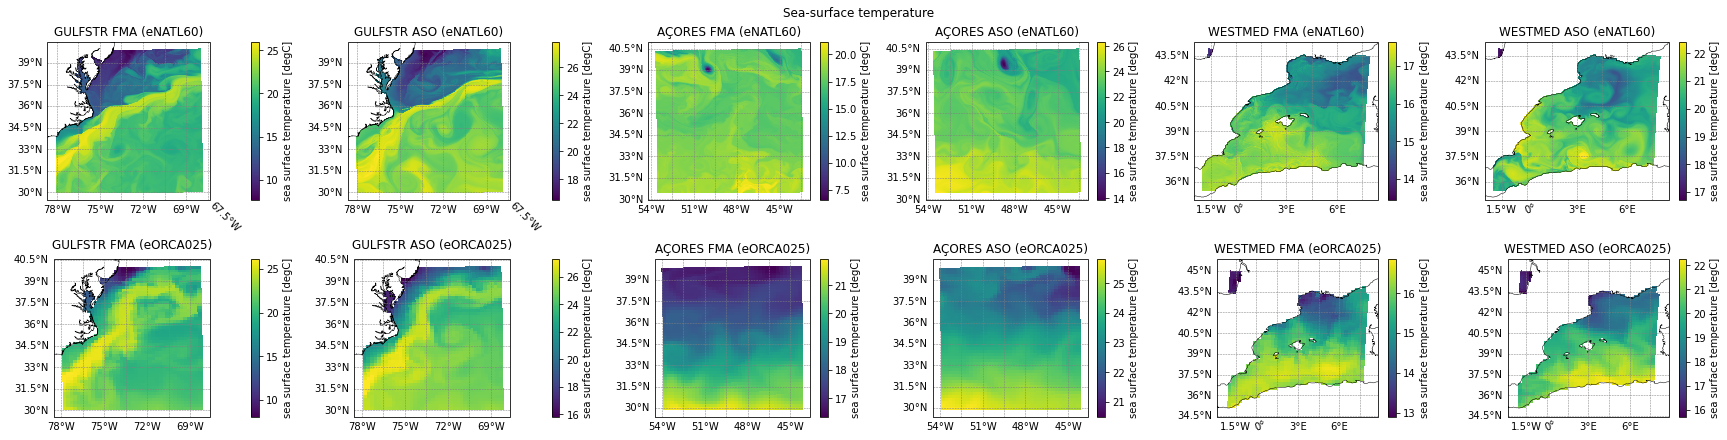

In [24]:
fig, axis = plt.subplots(ncols=len(data), nrows=2, figsize=(24,6), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)
fig.suptitle('Sea-surface temperature')
for col in range(len(data)) :
    for row, dataSetKey in enumerate(['HR', 'LR']) :
        data[col][dataSetKey].isel(time_counter=-1).sosstsst[coord_slice].plot(x='lon', y='lat', ax=axis[row,col])
        axis[row,col].set(title=data[col]['label'] + ' ('+data[col][dataSetKey].attrs['source']+')')

for ax in axis.flatten() :
    ax.coastlines(color='k', lw=0.5)
    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, color='grey', linestyle='dashed', linewidth=0.5)
    gl.top_labels = False; gl.right_labels = False

# "True" density

Compute conservative temperature and density anomaly $\sigma_0$ with the use of `gsw` library. Is computed before filtering.

In [25]:
%%time
for i in range(len(data)) :
    for dataKey in ['HR', 'LR'] :
        # conservative temperature
        data[i][dataKey]['CT'] = xr.apply_ufunc(gsw.conversions.CT_from_pt, data[i][dataKey]['sosaline'], data[i][dataKey]['sosstsst'], dask='parallelized').compute()
        # density anomaly (sigma0). denoted as 'true' since is computed on the basis of original (non-filtered) HR data
        data[i][dataKey]['sigma0_true'] = xr.apply_ufunc(gsw.density.sigma0, data[i][dataKey]['sosaline'], data[i][dataKey]['CT'], dask='parallelized').compute()
        # sqr of conservative temperature (to compute the subgrid variance further)
        data[i][dataKey]['CT_sqr'] = data[i][dataKey]['CT']**2
        data[i][dataKey]['sal_sqr'] = data[i][dataKey]['sosaline']**2

CPU times: user 1.74 s, sys: 974 ms, total: 2.72 s
Wall time: 5.89 s


# Filters

## Routines

In [26]:
def downsample(data, window_size, area_2d, wet_mask) :
    area_masked = area_2d*wet_mask
    data_weighted = area_masked*data
    data_weighted_sums = data_weighted.coarsen(x=window_size, y=window_size, boundary='trim', \
                                           coord_func={'x':'mean', 'y':'mean', 'lat':'mean', 'lon':'mean'}).sum(skipna=True)
    area_window_sums = area_masked.coarsen(x=window_size, y=window_size, boundary='trim').sum(skipna=True)
    result = data_weighted_sums/area_window_sums
    result['x'] = np.arange(len(result['x']))
    result['y'] = np.arange(len(result['y']))
    
    # coarsened coordinates:
    new_e1t = data['e1t'].coarsen(x=window_size,boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).mean(skipna=True).coarsen(y=window_size, boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).sum(skipna=False).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'],errors='ignore')
    new_e2t = data['e2t'].coarsen(x=window_size,boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).mean(skipna=True).coarsen(y=window_size, boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).sum(skipna=False).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'],errors='ignore')
    result['e1t'] = (['y','x'], new_e1t.values) 
    result['e2t'] = (['y','x'], new_e2t.values) 
    
    # binarize and erode the mask (to remove isolated pixels)
    threshold = 0.0
    new_wetmask = ndimage.binary_erosion(np.where((result['tmask'] > threshold), 1.0, 0.0))
    result['tmask'] = (['y','x'], new_wetmask.astype(np.float32))
    #apply new mask to data
    result = result.where(result.tmask>0)
    return result

In [27]:
def apply_filter_downsample(dataHR, filter_coef, coarse_window_size) :
    data = dataHR.dropna(dim='y', thresh=3).dropna(dim='x', thresh=3)
    wet_mask = xr.DataArray(data.tmask, dims=['y','x'])
    area = xr.DataArray((data.e1t * data.e2t), dims=['y','x'])
    if (filter_coef > 0) :
        # Filtering with a fixed factor
        dxw = xr.DataArray(data.e1u, dims=['y','x']) # x-spacing centered at western cell edge
        dyw = xr.DataArray(data.e2u, dims=['y','x']) # y-spacing centered at western cell edge
        dxs = xr.DataArray(data.e1v, dims=['y','x']) # x-spacing centered at southern cell edge
        dys = xr.DataArray(data.e2v, dims=['y','x']) # y-spacing centered at southern cell edge
        dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min()).values
        dx_max = max(dxw.max(),dys.max()).values
        filter_scale = filter_coef*dx_max
#         kappa_w = xr.ones_like(dxw)
#         kappa_s = xr.ones_like(dxw)
        kappa_w = dxw * dxw / (dx_max * dx_max)
        kappa_s = dys * dys / (dx_max * dx_max)
        # define the filter
        gaussian_filter = gcm_filters.Filter(
            n_iterations=2,
            filter_scale=filter_scale,    
             dx_min=dx_min,
            filter_shape=gcm_filters.FilterShape.GAUSSIAN,
            grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
            grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
                'kappa_w': kappa_w, 'kappa_s': kappa_s} )
        # apply filter to HR data
        data_filtered = xr.Dataset({}, coords=data.coords)
        data_filtered = gaussian_filter.apply(data, dims=['y', 'x'])
    else :
        data_filtered =  xr.Dataset({}, coords=data.coords)
        data_filtered = data
    # spatial coarsening
    if (coarse_window_size > 0) :
        dataLR = downsample(data_filtered, coarse_window_size, area, wet_mask)
    else : 
        dataLR = data_filtered
    return dataLR

## Set of filters to compare

In [28]:
coarsening_window_size = 15
filters = [dict({'filter_coef' : 0, 'coarsening_window_size' : coarsening_window_size, 'interpolate' : False, 'label' : 'Coarse to 0.25°'}),
          dict({'filter_coef' : 15, 'coarsening_window_size' : coarsening_window_size, 'interpolate' : False, 'label' : 'Filter 0.25° + Coarse to 0.25°'}),
          dict({'filter_coef' : 0, 'coarsening_window_size' : 2*coarsening_window_size, 'interpolate' : True, 'label' : 'Coarse to 0.5° + Interp to 0.25°'}),
          dict({'filter_coef' : 0, 'coarsening_window_size' : 4*coarsening_window_size, 'interpolate' : True, 'label' : 'Coarse to 1° + Interp to 0.25°'})]

In [29]:
regrid_method = 'bilinear'

In [30]:
%%time
%%capture --no-display
for i in range(len(data)) : 
    data[i]['HR_Filtered'] = [] 
    ref_data = data[i]['LR']
    out_grid = xr.DataArray(coords={'lon' : ref_data.lon, 'lat' : ref_data.lat, 'x': ref_data.x, 'y': ref_data.y}, dims=['y', 'x'])
    for ifilter, curr_filter in enumerate(filters) :
        filtered = apply_filter_downsample(data[i]['HR'], curr_filter['filter_coef'], curr_filter['coarsening_window_size']).compute().\
                                                               chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
        if (curr_filter['interpolate']):
            regridder = xe.Regridder(filtered, out_grid, regrid_method, unmapped_to_nan=True)
            regridded = regridder(filtered)
            regridded.coords['e1t'] = ref_data.e1t
            regridded.coords['e2t'] = ref_data.e2t
            data[i]['HR_Filtered'].append(regridded)
        else :
            data[i]['HR_Filtered'].append(filtered)

CPU times: user 1min 39s, sys: 16.7 s, total: 1min 56s
Wall time: 3min 7s


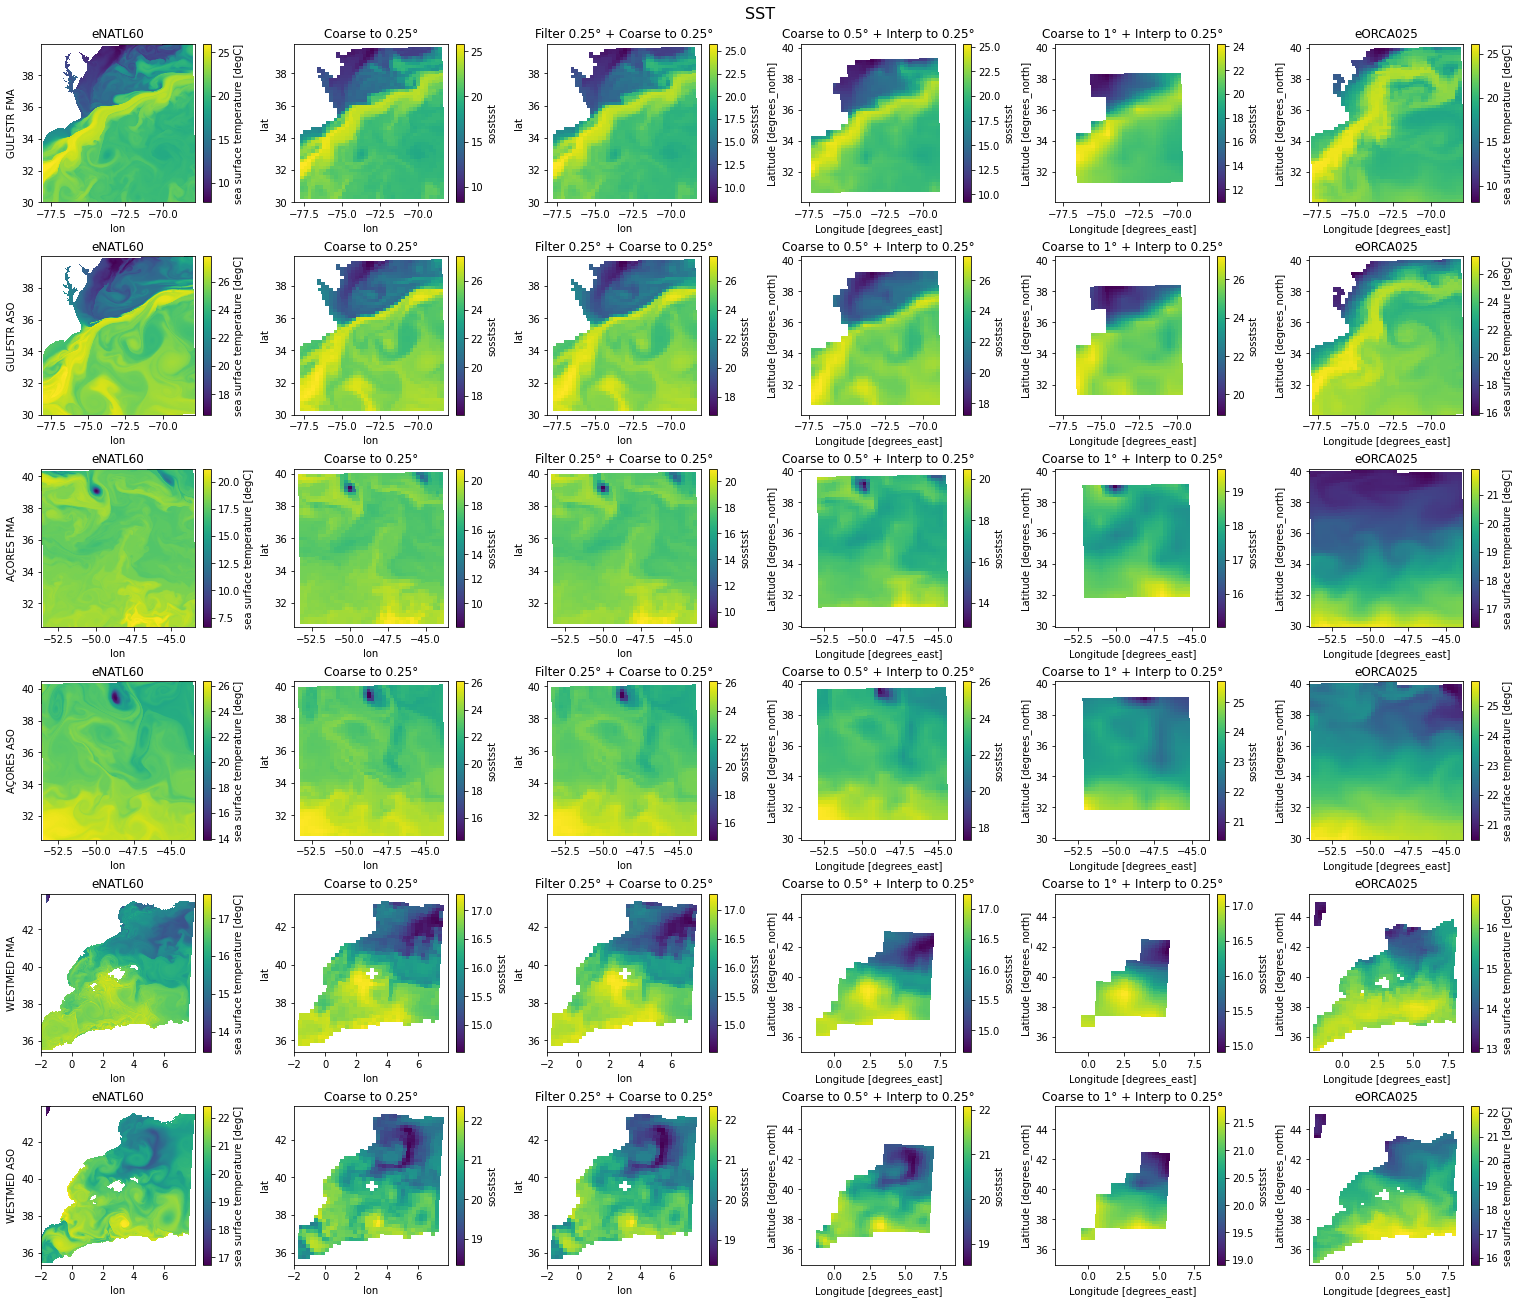

In [31]:
ncols = len(filters)+2 
nrows=len(data)
fig, axis = plt.subplots(ncols=ncols, nrows=nrows, figsize=(3.5*ncols,3*nrows), constrained_layout=True)
quantity='sosstsst'
fig.suptitle('SST', size=16)
for row in range(len(data)) :
    data[row]['HR'].isel(time_counter=-1)[quantity].plot(x='lon', y='lat', ax=axis[row,0])
    axis[row,0].set(title='eNATL60')
    for ifilter in range(len(filters)) :
        col = ifilter+1
        data[row]['HR_Filtered'][ifilter].isel(time_counter=-1)[quantity].plot(x='lon', y='lat', ax=axis[row,col])
        axis[row,col].set(title=filters[ifilter]['label'])
    data[row]['LR'].isel(time_counter=-1)[quantity].plot(x='lon', y='lat', ax=axis[row,-1])
    axis[row,-1].set(title='eORCA025')    
    axis[row,0].set(ylabel=data[row]['label'])

# Compute the subgrid variance and density error

Subgrid variance for temperature and salinity is computed as:
$$ \sigma_T^2 = \overline{T^2} -  \overline{T}^2 $$
$$ \sigma_S^2 = \overline{S^2} - \overline{S}^2 $$

The density error is computed as differene between the density obtained by filtering the HR density and the one evaluated on the basis of filtered temperature and salinity:
$$ \Delta \rho =  \overline{\rho(T,S)} - \rho(\overline{T}, \overline{S}) $$

In [32]:
%%time
for i in range(len(data)) :
    for ds in [data[i]['HR_Filtered'][ifilter] for ifilter in range(len(filters))] :
        # conservative temperature
        ds['CT'] = xr.apply_ufunc(gsw.conversions.CT_from_pt, ds['sosaline'], ds['sosstsst'], dask='parallelized').compute()
        # subgrid temp variance
        ds['var_T'] = ds['CT_sqr'] - ds['CT']**2
        ds['var_S'] = ds['sal_sqr'] - ds['sosaline']**2
        # density correction
        ds['sigma0_model'] = xr.apply_ufunc(gsw.density.sigma0, ds['sosaline'], ds['CT'], dask='parallelized').compute()
        ds['sigma0_delta'] = ds['sigma0_true'] - ds['sigma0_model']

CPU times: user 1.32 s, sys: 52.9 ms, total: 1.37 s
Wall time: 3.06 s


Compute the second derivatives of the density with the respect to temperature and salinity (known from the EOS)

In [33]:
%%time
for i in range(len(data)) :
    for ds in [data[i]['HR']] + [data[i]['HR_Filtered'][ifilter] for ifilter in range(len(filters))] + [data[i]['LR']] :
        ds['rho_sa_sa'], ds['rho_sa_ct'], ds['rho_ct_ct'] = eos_module.rho_second_derivatives(ds['sosaline'], ds['CT'])

CPU times: user 30.8 s, sys: 362 ms, total: 31.2 s
Wall time: 31.2 s


## Plots of true subgrid temperature variance

In [34]:
x_slice = slice(1,-1)
y_slice = slice(1,-1)
bord_cut = dict(y=y_slice,x=x_slice) # to cut borders 

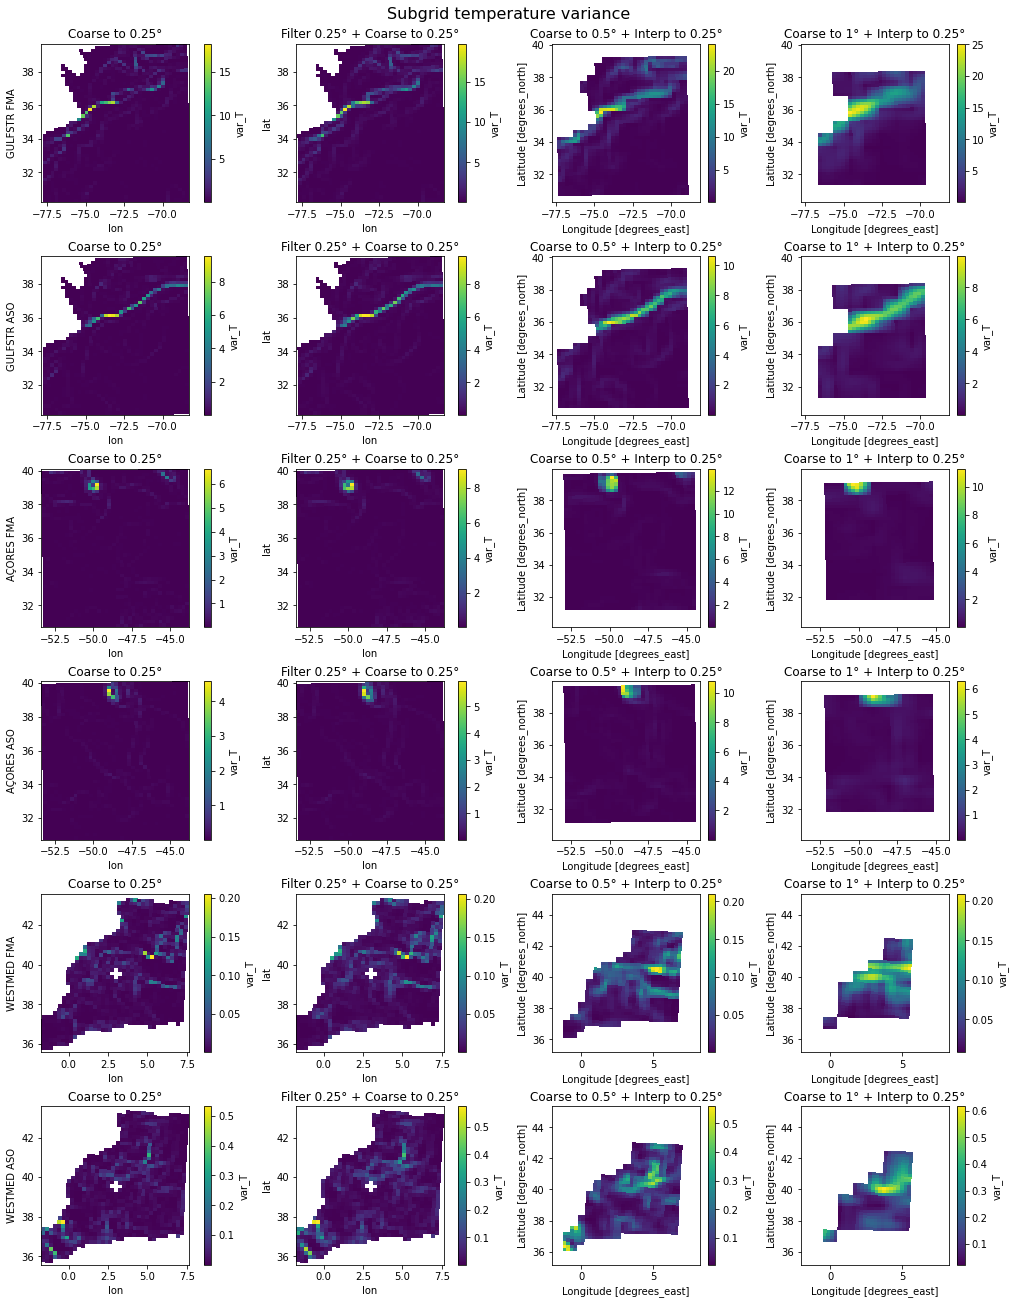

In [35]:
ncols = len(filters)
nrows=len(data)
fig, axis = plt.subplots(ncols=ncols, nrows=nrows, figsize=(3.5*ncols,3*nrows), constrained_layout=True)
quantity='var_T'
fig.suptitle('Subgrid temperature variance', size=16)
for row in range(len(data)) :
    for ifilter in range(len(filters)) :
        col = ifilter
        var = data[row]['HR_Filtered'][ifilter].isel(time_counter=-1)[quantity]
        (var.where(var>0))[bord_cut].plot(x='lon', y='lat', ax=axis[row,col], cmap='viridis')
        axis[row,col].set(title=filters[ifilter]['label'])   
    axis[row,0].set(ylabel=data[row]['label'])

In [36]:
# initialize data structure for storing histograms
hists=[dict() for i in range(len(data))]
for i in range(len(data)) :
    hists[i]['HR_Filtered'] = [dict({'label' : filters[ifilter]['label']}) for ifilter in range(len(filters))] 
    hists[i]['HR'] = dict({'label' : 'eNATL60'})
    hists[i]['LR'] = dict({'label' : 'eORCA025'})

# Deterministic parametrization for the density error

From (Stanley et al 2021), the density correction is determined mainly by the temperature subgrid variance $\sigma^2_T$ and the local second derivative of the density with the respect to temperature (known from the EOS) evaluated on the basis of filtered fields. 
$$ \rho_c = \frac{1}{2} \frac{\partial^2 \rho (\bar{T}, \bar{S})}{\partial \bar{T}^2} \sigma_T^2 + \frac{\partial^2 \rho (\bar{T}, \bar{S})}{\partial \bar{T} \partial \bar{S}} \sigma_T \sigma_S +  \frac{1}{2} \frac{\partial^2 \rho (\bar{T}, \bar{S})}{\partial \bar{S}^2} \sigma_S^2 $$
It is assumed that the most important contribution comes from the temperature variance term:
$$ \rho_c \approx \frac{1}{2} \frac{\partial^2 \rho (\bar{T}, \bar{S})}{\partial \bar{T}^2} \sigma_T^2 $$
It is proposed to estimate the temperature and salinity subgrid variance with local gradient (computed numerically through finite differences):
$$ \sigma_T^2 \approx \mathscr{s}_T^2 \equiv c |\delta \textbf{x} \cdot \nabla \bar{T}|^2 $$ 
where the coefficient $c$ can depend on the resolution. The theoretcal estimate is $c=1/12$. The values found from fitting of the data is $c=0.2$.

# 1st assumption: link between the "true" density error and the "true" subgrid variance of temperature/salinity 

Here, we will try to test the first assumption in the parametrization: the link between the density error and the true subgrid variance.
In particular, we will consider the expression including the "total" variance (of temperature, salinity and the mixed one):
$$ \rho_c = \frac{1}{2} \frac{\partial^2 \rho (\bar{T}, \bar{S})}{\partial \bar{T}^2} \sigma_T^2 + \frac{\partial^2 \rho (\bar{T}, \bar{S})}{\partial \bar{T} \partial \bar{S}} \sigma_T \sigma_S +  \frac{1}{2} \frac{\partial^2 \rho (\bar{T}, \bar{S})}{\partial \bar{S}^2} \sigma_S^2 $$
and the approximate simplified expression with the "only-temperature" variance (as the temperature contributes the most):
$$ \rho_c \approx \frac{1}{2} \frac{\partial^2 \rho (\bar{T}, \bar{S})}{\partial \bar{T}^2} \sigma_T^2  $$
For this purpose, the spatial covariance between 2D maps of the r.h.s. of expressions above and the "true" desity error is computed. Note that ar this point the "true" subgrid variances of temperature and salinity are used (they are not parametrized yet). </br>
Another way to establish statistical link between the density error and the subgrid varinca is to check the 2D histograms, where one variable is the true density error $\rho_c$ and another variable is the r.h.s. of the expressions above. The histograms are then fitted linearly.

In [37]:
%%time
for i in range(len(data)) :
    for ds in [data[i]['HR_Filtered'][ifilter] for ifilter in range(len(filters))]:
        ds["var_T_dens_deriv"] = 0.5*ds['rho_ct_ct']*ds["var_T"]
        ds["var_S_dens_deriv"] = 0.5*ds['rho_sa_sa']*ds["var_S"]
        ds["total_var_dens_deriv"] = ds["var_T_dens_deriv"] + ds['rho_sa_ct']*np.sqrt(ds["var_S"])*np.sqrt(ds["var_T"]) + ds["var_S_dens_deriv"]

CPU times: user 612 ms, sys: 839 µs, total: 613 ms
Wall time: 612 ms


## Spatial covariance between the density error and the true subgrid variance

In [38]:
%%time
for i in range(len(data)) :
    for ifilter in range(len(filters)):
        hists[i]['HR_Filtered'][ifilter]['corr_error_vs_var_T'] = xr.corr(data[i]['HR_Filtered'][ifilter]['var_T_dens_deriv'], data[i]['HR_Filtered'][ifilter]['sigma0_delta'], \
                                                                          dim=['x', 'y']).compute()
        hists[i]['HR_Filtered'][ifilter]['corr_error_vs_var_total'] = xr.corr(data[i]['HR_Filtered'][ifilter]['total_var_dens_deriv'], data[i]['HR_Filtered'][ifilter]['sigma0_delta'], \
                                                                          dim=['x', 'y']).compute()

CPU times: user 8.72 s, sys: 136 ms, total: 8.86 s
Wall time: 17.3 s


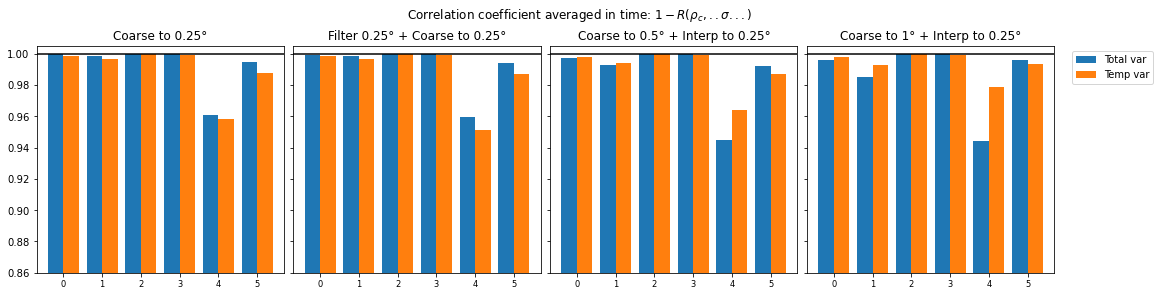

In [76]:
fig, ax = plt.subplots(1, 4, constrained_layout=True, figsize=(16, 4), sharey=True)
fig.suptitle(r'Correlation coefficient averaged in time: $1-R(\rho_c, ..\sigma...)$')
x = np.arange(6)
bar_width = 0.4
for ifilter in range(len(filters)) :
    for iq, quantity in enumerate(['corr_error_vs_var_total', 'corr_error_vs_var_T']) :
        ax[ifilter].bar(x+iq*bar_width, [(hists[region]['HR_Filtered'][ifilter][quantity].mean()) for region in range(len(data))], width=bar_width)
    ax[ifilter].set(title=filters[ifilter]['label'])
ax[-1].legend(labels={r'Total var', 'Temp var'}, bbox_to_anchor=(1.05, 1), loc='upper left')
for axis in ax :
    axis.set_xticks(x + 0.5*bar_width)
    axis.axhline(y=1., color='k')
    #axis.set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=10)
    axis.set_xticklabels([region for region in range(len(data))],fontsize=10)
    axis.xaxis.set_tick_params(labelsize='small')
    axis.set(yscale='linear', ylim=[0.86,1.005])
plt.show()

- The plots for spatial covariance between the density error and the temperature/salinity subgrid variance demostrate that these quantites are strongly correlated in space. 
- If the high-resolution fields are coarsed to the resolution 0.25deg (first two plots), the expression for the 'total' subgrid variance (including both tempreature and salinity, as well as theit mixed variance) gives slightly better correlation coefficient (the blue plots bars are lower), comparing to the purely temperature-variance expression (orange plot bars).
- Coarsening to lower resolutions (0.5deg, 1deg) leads to a reduction of the correlation coefficient in general
- From this analysis, it appears that when coarsening or filtering+coarsening to 0.25deg is applied to the data, the locations with strong subgrid variance of temperature and salinity almost coincide with the locations with density error, meaning that this parametrization is expected to provide correct result. Is one dowgrades the HR more (coarse to 0.5 ot 1degree), the correlation coefficient decreases, and this change is rather different for different regions and seasons. 

## 2D histograms of density error and subgrid variance

$$ H \left(\rho_c, \frac{1}{2} \frac{\partial^2 \rho (\bar{T}, \bar{S})}{\partial \bar{T}^2} \sigma_T^2 + \frac{\partial^2 \rho (\bar{T}, \bar{S})}{\partial \bar{T} \partial \bar{S}} \sigma_T \sigma_S +  \frac{1}{2} \frac{\partial^2 \rho (\bar{T}, \bar{S})}{\partial \bar{S}^2} \sigma_S^2 \right) $$

### "Total" variance (temperature/salinity/mixed)

In [40]:
%%time
name_hist = 'hist_error_vs_var_total'
x = 'total_var_dens_deriv'
y = 'sigma0_delta'
for i in range(len(data)) :
    # reference histogram
    ref_case = 0
    hists[i]['HR_Filtered'][ref_case][name_hist] = compute_2D_histogram(data[i]['HR_Filtered'][ref_case][bord_cut], x, y, nb_of_bins).compute()
    ref_hist = hists[i]['HR_Filtered'][ref_case][name_hist]
    bins = [ref_hist[x+'_bin'].values, ref_hist[y+'_bin'].values]
    for ifilter in range(len(filters)) :
        hists[i]['HR_Filtered'][ifilter][name_hist] = compute_2D_histogram(data[i]['HR_Filtered'][ifilter][bord_cut], x, y, nb_of_bins, bins=bins).compute()
        [hists[i]['HR_Filtered'][ifilter][name_hist].attrs['slope'], hists[i]['HR_Filtered'][ifilter][name_hist].attrs['increment'], \
         hists[i]['HR_Filtered'][ifilter][name_hist].attrs['residuals'], hists[i]['HR_Filtered'][ifilter][name_hist].attrs['mean_x'], hists[i]['HR_Filtered'][ifilter][name_hist].attrs['mean_y']] = \
        fit_2D_histogram(hists[i]['HR_Filtered'][ifilter][name_hist])

CPU times: user 5.11 s, sys: 85.9 ms, total: 5.19 s
Wall time: 9.75 s


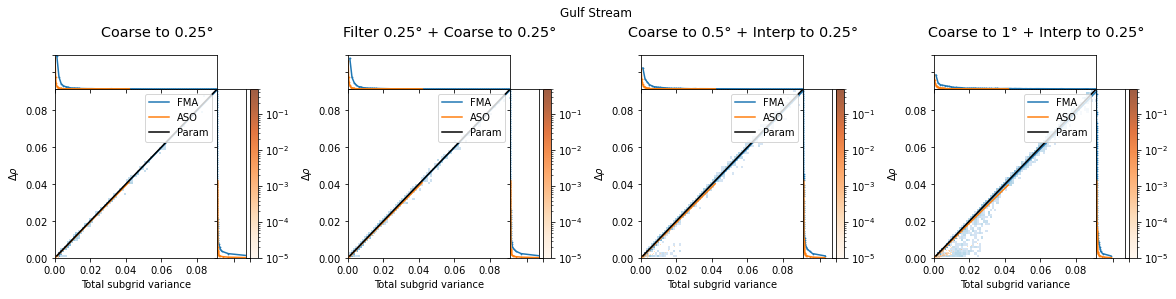

In [41]:
fig, axs = plt.subplots(1, 4, constrained_layout=True, figsize=(16, 4))
fig.suptitle('Gulf Stream')
name_hist = 'hist_error_vs_var_total'
x = 'total_var_dens_deriv'
y = 'sigma0_delta'
region=0
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = fig.subfigures(1, 4, wspace=0.07)
for a in axs:
    for spine in ['top', 'right', 'bottom', 'left'] :
        a.spines[spine].set_visible(False)
    a.get_xaxis().set_ticks([]); a.get_yaxis().set_ticks([])    
gs = GridSpec(2, 3, width_ratios=[10, 2.0, 1], height_ratios=[2.0, 10], wspace=0, hspace=0)
for i in range(len(filters)) :
    subfigs[i].suptitle(filters[i]['label'], fontsize='x-large')
    big_ax = subfigs[i].add_subplot(gs[1,0]) # bottom left
    top_ax = subfigs[i].add_subplot(gs[0,0], sharex=big_ax) # top left
    right_ax = subfigs[i].add_subplot(gs[1,1], sharey=big_ax) # bottom center
    cbar_ax = subfigs[i].add_subplot(gs[1,2]) # bottom right
    cbar_ax.set(xticks=[], yticks=[])
    hist_joint = margin_hist(hists[region]['HR_Filtered'][i][name_hist], 0, x+'_bin', y+'_bin', top_ax, right_ax, big_ax)
    hist_joint = margin_hist(hists[region+1]['HR_Filtered'][i][name_hist], 1, x+'_bin', y+'_bin', top_ax, right_ax, big_ax)
    x_points = hists[region]['HR_Filtered'][ifilter][name_hist][x+'_bin']
    big_ax.plot(x_points, 1.*x_points, 'k', label='Param')
    big_ax.set(xlabel=r'Total subgrid variance', ylabel=r'$\Delta \rho$', xscale='linear', yscale='linear')
    big_ax.legend(handles=big_ax.lines, labels=['FMA', 'ASO', 'Param'], loc='upper right')
    big_ax.set(xlim=[0,0.5*hists[region]['HR_Filtered'][i][name_hist][x+'_bin'].max()],\
              ylim=[0,0.5*hists[region]['HR_Filtered'][i][name_hist][y+'_bin'].max()])
    subfigs[i].colorbar(hist_joint, ax=cbar_ax, anchor=(0.0, 0.0),pad=0.25,fraction=1.)
plt.show()

### Only-temperature variance

$$ H \left(\rho_c, \frac{1}{2} \frac{\partial^2 \rho (\bar{T}, \bar{S})}{\partial \bar{T}^2} \sigma_T^2 \right) $$

In [42]:
%%time
name_hist = 'hist_error_vs_var_T'
x = 'var_T_dens_deriv'
y = 'sigma0_delta'
for i in range(len(data)) :
    # reference histogram
    ref_case = 0
    hists[i]['HR_Filtered'][ref_case][name_hist] = compute_2D_histogram(data[i]['HR_Filtered'][ref_case][bord_cut], x, y, nb_of_bins).compute()
    ref_hist = hists[i]['HR_Filtered'][ref_case][name_hist]
    bins = [ref_hist[x+'_bin'].values, ref_hist[y+'_bin'].values]
    for ifilter in range(len(filters)) :
        hists[i]['HR_Filtered'][ifilter][name_hist] = compute_2D_histogram(data[i]['HR_Filtered'][ifilter][bord_cut], x, y, nb_of_bins, bins=bins).compute()
        [hists[i]['HR_Filtered'][ifilter][name_hist].attrs['slope'], hists[i]['HR_Filtered'][ifilter][name_hist].attrs['increment'], \
         hists[i]['HR_Filtered'][ifilter][name_hist].attrs['residuals'], hists[i]['HR_Filtered'][ifilter][name_hist].attrs['mean_x'], hists[i]['HR_Filtered'][ifilter][name_hist].attrs['mean_y']] = \
        fit_2D_histogram(hists[i]['HR_Filtered'][ifilter][name_hist])

CPU times: user 3.35 s, sys: 75.8 ms, total: 3.42 s
Wall time: 7.84 s


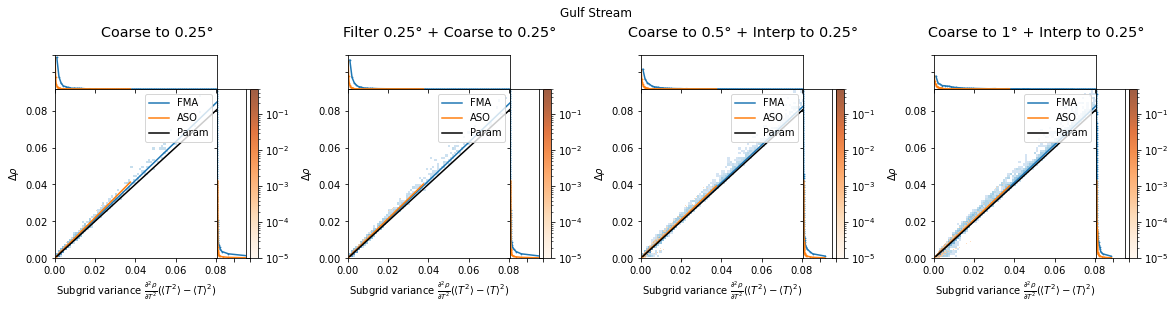

In [43]:
fig, axs = plt.subplots(1, 4, constrained_layout=True, figsize=(16, 4))
fig.suptitle('Gulf Stream')
name_hist = 'hist_error_vs_var_T'
x = 'var_T_dens_deriv'
y = 'sigma0_delta'
region=0
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = fig.subfigures(1, 4, wspace=0.07)
for a in axs:
    for spine in ['top', 'right', 'bottom', 'left'] :
        a.spines[spine].set_visible(False)
    a.get_xaxis().set_ticks([]); a.get_yaxis().set_ticks([])    
gs = GridSpec(2, 3, width_ratios=[10, 2.0, 1], height_ratios=[2.0, 10], wspace=0, hspace=0)
for i in range(len(filters)) :
    subfigs[i].suptitle(filters[i]['label'], fontsize='x-large')
    big_ax = subfigs[i].add_subplot(gs[1,0]) # bottom left
    top_ax = subfigs[i].add_subplot(gs[0,0], sharex=big_ax) # top left
    right_ax = subfigs[i].add_subplot(gs[1,1], sharey=big_ax) # bottom center
    cbar_ax = subfigs[i].add_subplot(gs[1,2]) # bottom right
    cbar_ax.set(xticks=[], yticks=[])
    hist_joint = margin_hist(hists[region]['HR_Filtered'][i][name_hist], 0, x+'_bin', y+'_bin', top_ax, right_ax, big_ax)
    hist_joint = margin_hist(hists[region+1]['HR_Filtered'][i][name_hist], 1, x+'_bin', y+'_bin', top_ax, right_ax, big_ax)
    x_points = hists[region]['HR_Filtered'][ifilter][name_hist][x+'_bin']
    big_ax.plot(x_points, 1.*x_points, 'k', label='Param')
    big_ax.set(xlabel=r'Subgrid variance $\frac{\partial^2 \rho}{\partial T^2} (\langle T^2\rangle - \langle T\rangle^2)$', ylabel=r'$\Delta \rho$', xscale='linear', yscale='linear')
    big_ax.legend(handles=big_ax.lines, labels=['FMA', 'ASO', 'Param'], loc='upper right')
    big_ax.set(xlim=[0,0.5*hists[region]['HR_Filtered'][i][name_hist][x+'_bin'].max()],\
              ylim=[0,0.5*hists[region]['HR_Filtered'][i][name_hist][y+'_bin'].max()])
    subfigs[i].colorbar(hist_joint, ax=cbar_ax, anchor=(0.0, 0.0),pad=0.25,fraction=1.)
plt.show()

### Linear fit of histograms and comparison

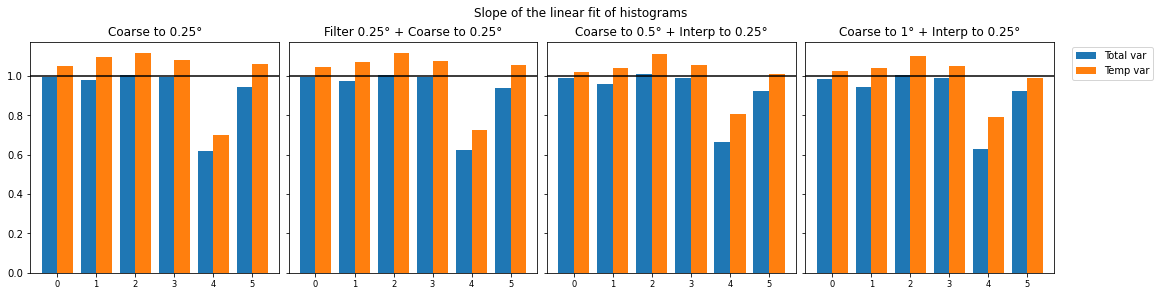

In [44]:
fig, ax = plt.subplots(1, 4, constrained_layout=True, figsize=(16, 4), sharey=True)
fig.suptitle(r'Slope of the linear fit of histograms')
x = np.arange(6)
bar_width = 0.4
for ifilter in range(len(filters)) :
    for iq, quantity in enumerate(['hist_error_vs_var_total', 'hist_error_vs_var_T']) :
        ax[ifilter].bar(x+iq*bar_width, [hists[region]['HR_Filtered'][ifilter][quantity].attrs['slope'] for region in range(len(data))], width=bar_width)
    ax[ifilter].set(title=filters[ifilter]['label'])
ax[-1].legend(labels={r'Total var', 'Temp var'}, bbox_to_anchor=(1.05, 1), loc='upper left')
for axis in ax :
    axis.set_xticks(x + 0.5*bar_width)
    axis.axhline(y=1., color='k')
    #axis.set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=10)
    axis.set_xticklabels([region for region in range(len(data))],fontsize=10)
    axis.xaxis.set_tick_params(labelsize='small')
    axis.set(yscale='linear')
plt.show()

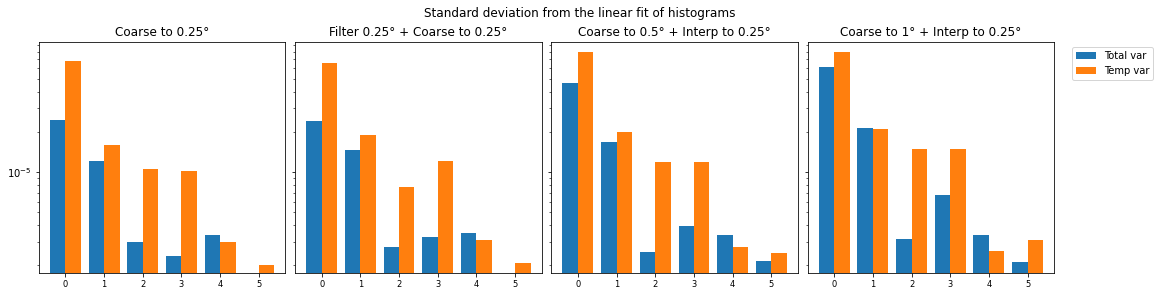

In [45]:
fig, ax = plt.subplots(1, 4, constrained_layout=True, figsize=(16, 4), sharey=True)
fig.suptitle(r'Standard deviation from the linear fit of histograms')
x = np.arange(6)
bar_width = 0.4
for ifilter in range(len(filters)) :
    for iq, quantity in enumerate(['hist_error_vs_var_total', 'hist_error_vs_var_T']) :
        ax[ifilter].bar(x+iq*bar_width, [np.sqrt(hists[region]['HR_Filtered'][ifilter][quantity].attrs['residuals']) for region in range(len(data))], width=bar_width)
    ax[ifilter].set(title=filters[ifilter]['label'])
ax[-1].legend(labels={r'Total var', 'Temp var'}, bbox_to_anchor=(1.05, 1), loc='upper left')
for axis in ax :
    axis.set_xticks(x + 0.5*bar_width)
    #axis.axhline(y=1., color='k')
    #axis.set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=10)
    axis.set_xticklabels([region for region in range(len(data))],fontsize=10)
    axis.xaxis.set_tick_params(labelsize='small')
    axis.set(yscale='log')
plt.show()

Observations :
- Fortunately, fitting the histograms gives similar slope more or less independently of the filtering/coarsening scheme. 
- Different regions and seasons show almost the same slope, except Westmed, especially winter (?). This could indicate that in this region there could be other contributions to the density error (could be presence of boundaries + contribution of "badly" averaged 1st derivative in Taylor expansion, or contribution of higher order terms)
- The "only-temperature" variance gives in general slighter larger slope and larger standard deviation. 
- The standard deviation and the spread of the points on the histograms increases when coarsening to lower resolutions, meaning that the approximation works worse.

# 2nd assumptiom: link between the true subgrid variance and its parametrization through spatial derivatives

Proposed parametrization links the subgrid temperature variance with its spatial gradient:

$$ \sigma_T^2 \approx \mathscr{s}_T^2 \equiv c |\delta \textbf{x} \cdot \nabla \overline{T}|^2 $$ 
where 
$$ |\delta \textbf{x} \cdot \nabla \overline{T}|^2 (x,y) \equiv \frac{1}{4} \left[\overline{T}(x+\Delta x, y) - \overline{T}(x - \Delta x, y)\right]^2 + \frac{1}{4}\left[\overline{T}(x, y+\Delta y) - \overline{T}(x, y- \Delta y)\right]^2 $$
and the same for salinity.

In [77]:
# def diffs_x(dataArray) :
#     return (dataArray.shift(x=-1) - dataArray)
# def diffs_y(dataArray) :
#     return (dataArray.shift(y=-1) - dataArray)
def central_diffs_x(dataArray) :
    return 0.5*(dataArray.shift(x=-1) - dataArray.shift(x=1))
def central_diffs_y(dataArray) :
    return 0.5*(dataArray.shift(y=-1) - dataArray.shift(y=1))

In [88]:
%%time
for i in range(len(data)) :
    for ds in [data[i]['HR']] + [data[i]['HR_Filtered'][ifilter] for ifilter in range(len(filters))] + [data[i]['LR']] :
        ds["diff_T_sqr"] = central_diffs_x(ds['CT'])**2 + central_diffs_y(ds['CT'])**2
        ds["diff_S_sqr"] = central_diffs_x(ds['sosaline'])**2 + central_diffs_y(ds['sosaline'])**2

CPU times: user 1.88 s, sys: 63.4 ms, total: 1.94 s
Wall time: 1.94 s


## Plot surface snapshots to compare

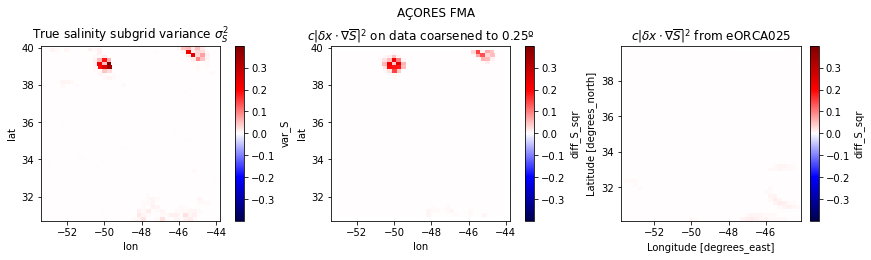

In [80]:
fig, ax = plt.subplots(1, 3, constrained_layout=True, figsize=(12, 3.5))
region = 2
ifilter = 0
fig.suptitle(data[region]['label'])
cmap = 'seismic'

plot0 = data[region]['HR_Filtered'][ifilter].isel(time_counter=-1)['var_S'][bord_cut].plot(x='lon', y='lat', ax=ax[0], cmap=cmap)
ax[0].set(title=r'True salinity subgrid variance $\sigma_S^2$')

plot1 =(0.2*data[region]['HR_Filtered'][ifilter].isel(time_counter=-1)['diff_S_sqr'][bord_cut]).plot(x='lon', y='lat', ax=ax[1], \
                                                                                                        cmap=cmap, vmin=plot0.colorbar.vmin, vmax=plot0.colorbar.vmax)
ax[1].set(title=r'$c|\delta {x} \cdot \nabla \overline{S}|^2$ on data coarsened to 0.25º')
plot1.colorbar = plot0.colorbar

data[region]['LR'].isel(time_counter=-1)['diff_S_sqr'][bord_cut].plot(x='lon', y='lat', ax=ax[2], cmap=cmap, vmin=plot0.colorbar.vmin, vmax=plot0.colorbar.vmax)
ax[2].set(title=r'$c|\delta {x} \cdot \nabla \overline{S}|^2$ from eORCA025')
plt.show()

## Spatial covariance between the true subgrid variance and the squares of gradients

Spatial correlation coefficient $R$ between the 'true' subgrid temperature variance $\sigma_T^2$ and the squared differences $|\delta \textbf{x} \cdot \nabla \bar{T}|^2$

In [81]:
%%time
for i in range(len(data)) :
    for ifilter in range(len(filters)):
        hists[i]['HR_Filtered'][ifilter]['corr_var_T_vs_diff_T_sqr'] = xr.corr(data[i]['HR_Filtered'][ifilter]['diff_T_sqr'], data[i]['HR_Filtered'][ifilter]['var_T'], \
                                                                          dim=['x', 'y']).compute()
        hists[i]['HR_Filtered'][ifilter]['corr_var_S_vs_diff_S_sqr'] = xr.corr(data[i]['HR_Filtered'][ifilter]['diff_S_sqr'], data[i]['HR_Filtered'][ifilter]['var_S'], \
                                                                          dim=['x', 'y']).compute()

CPU times: user 3.93 s, sys: 84.3 ms, total: 4.01 s
Wall time: 12.2 s


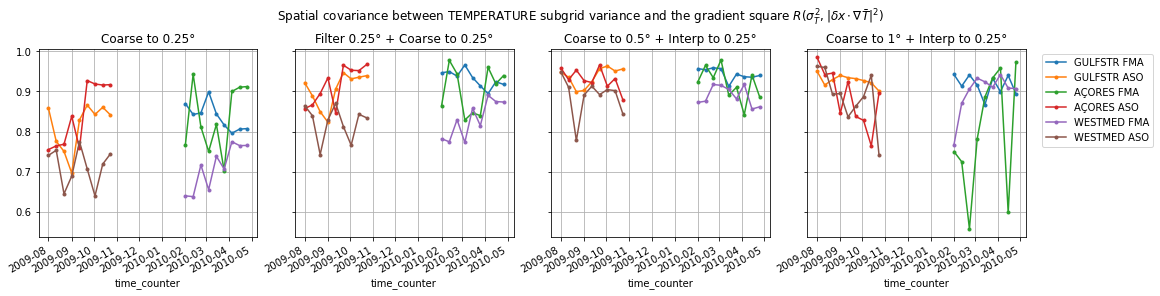

In [82]:
fig, ax = plt.subplots(1, 4, constrained_layout=True, figsize=(16, 4), sharey=True) 
fig.suptitle(r'Spatial covariance between TEMPERATURE subgrid variance and the gradient square $R(\sigma_T^2, |\delta {x} \cdot \nabla \bar{T}|^2)$')
for ifilter in range(len(filters)):
    for i in range(len(data)) :
        hists[i]['HR_Filtered'][ifilter]['corr_var_T_vs_diff_T_sqr'].plot(ax=ax[ifilter], ls='-', marker='.', label=data[i]['label'])
    ax[ifilter].set(title=filters[ifilter]['label']); ax[ifilter].grid(True)    
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

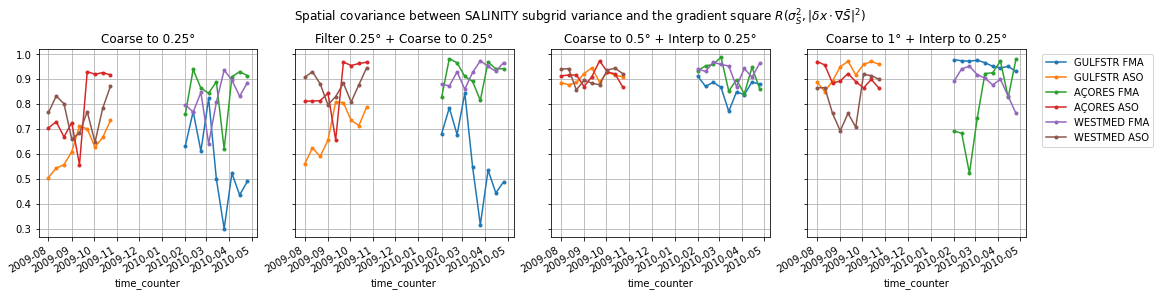

In [83]:
fig, ax = plt.subplots(1, 4, constrained_layout=True, figsize=(16, 4), sharey=True) 
fig.suptitle(r'Spatial covariance between SALINITY subgrid variance and the gradient square $R(\sigma_S^2, |\delta {x} \cdot \nabla \bar{S}|^2)$')
for ifilter in range(len(filters)):
    for i in range(len(data)) :
        hists[i]['HR_Filtered'][ifilter]['corr_var_S_vs_diff_S_sqr'].plot(ax=ax[ifilter], ls='-', marker='.', label=data[i]['label'])
    ax[ifilter].set(title=filters[ifilter]['label']); ax[ifilter].grid(True)    
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

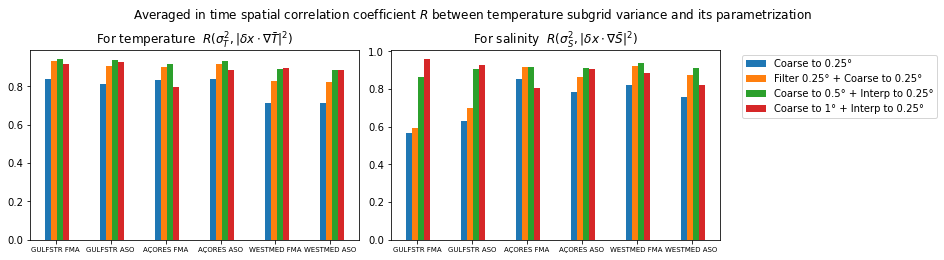

In [84]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(13, 3.5))
fig.suptitle(r'Averaged in time spatial correlation coefficient $R$ between temperature subgrid variance and its parametrization')
x = np.arange(6)
bar_width = 0.11
for ifilter in range(len(filters)) :
    ax[0].bar(x+ifilter*bar_width, [hists[region]['HR_Filtered'][ifilter]['corr_var_T_vs_diff_T_sqr'].mean() for region in range(len(data))], width=bar_width,\
          label=filters[ifilter]['label'])
    ax[1].bar(x+ifilter*bar_width, [hists[region]['HR_Filtered'][ifilter]['corr_var_S_vs_diff_S_sqr'].mean() for region in range(len(data))], width=bar_width,\
          label=filters[ifilter]['label'])
ax[0].set(title=r'For temperature  $R(\sigma_T^2, |\delta {x} \cdot \nabla \bar{T}|^2)$')
ax[1].set(title=r'For salinity  $R(\sigma_S^2, |\delta {x} \cdot \nabla \bar{S}|^2)$')
for axis in ax: 
    axis.set_xticks(x + 1.25*bar_width)
    axis.set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=7)
    #axis.xaxis.set_tick_params(labelsize='small')
    axis.set(yscale='linear')

ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Observations: 
- Adding filtering before coarsening (orange bars) improves spatial correlation between the 'true' subgrid variance and the parametrization, especially for temperature. Surprisingly, corsening to lower resolution alreas improves spatial covariance (?)
- Correlation coefficient varies with regions, especially for salinity. Something is really wrong with salinity gradients/variance in Gulf Stream, apparently the problem in the vicinity of the boundaries (try masking out the boundaries for stats ???).
- Overall, the results show clear dependence on the choice of the filtering scheme. Which is expected, since filtering/coarsening operations influence a lot spatial numerical derivatives.

## 2D histograms of true variance and its parametrization

In [154]:
%%time
name_hist = 'hist_var_T'
x = 'diff_T_sqr'
y = 'var_T'
for i in range(len(data)) :
    # reference histogram
    ref_case = 0
    hists[i]['HR_Filtered'][ref_case][name_hist] = compute_2D_histogram(data[i]['HR_Filtered'][ref_case][bord_cut], x, y, nb_of_bins).compute()
    ref_hist = hists[i]['HR_Filtered'][ref_case][name_hist]
    bins = [ref_hist[x+'_bin'].values, ref_hist[y+'_bin'].values]
    for ifilter in range(len(filters)) :
        hists[i]['HR_Filtered'][ifilter][name_hist] = compute_2D_histogram(data[i]['HR_Filtered'][ifilter][bord_cut], x, y, nb_of_bins, bins=bins).compute()
        [hists[i]['HR_Filtered'][ifilter][name_hist].attrs['slope'], hists[i]['HR_Filtered'][ifilter][name_hist].attrs['increment'], \
         hists[i]['HR_Filtered'][ifilter][name_hist].attrs['residuals'], hists[i]['HR_Filtered'][ifilter][name_hist].attrs['mean_x'], hists[i]['HR_Filtered'][ifilter][name_hist].attrs['mean_y']] = \
        fit_2D_histogram(hists[i]['HR_Filtered'][ifilter][name_hist])

CPU times: user 2.11 s, sys: 46.6 ms, total: 2.16 s
Wall time: 5.7 s


In [161]:
%%time
name_hist = 'hist_var_S'
x = 'diff_S_sqr'
y = 'var_S'
for i in range(len(data)) :
    # reference histogram
    ref_case = 2
    hists[i]['HR_Filtered'][ref_case][name_hist] = compute_2D_histogram(data[i]['HR_Filtered'][ref_case][bord_cut], x, y, nb_of_bins).compute()
    ref_hist = hists[i]['HR_Filtered'][ref_case][name_hist]
    bins = [ref_hist[x+'_bin'].values, ref_hist[y+'_bin'].values]
    for ifilter in range(len(filters)) :
        hists[i]['HR_Filtered'][ifilter][name_hist] = compute_2D_histogram(data[i]['HR_Filtered'][ifilter][bord_cut], x, y, nb_of_bins, bins=bins).compute()
        [hists[i]['HR_Filtered'][ifilter][name_hist].attrs['slope'], hists[i]['HR_Filtered'][ifilter][name_hist].attrs['increment'], \
         hists[i]['HR_Filtered'][ifilter][name_hist].attrs['residuals'], hists[i]['HR_Filtered'][ifilter][name_hist].attrs['mean_x'], hists[i]['HR_Filtered'][ifilter][name_hist].attrs['mean_y']] = \
        fit_2D_histogram(hists[i]['HR_Filtered'][ifilter][name_hist])

CPU times: user 2.54 s, sys: 92.2 ms, total: 2.63 s
Wall time: 7.75 s


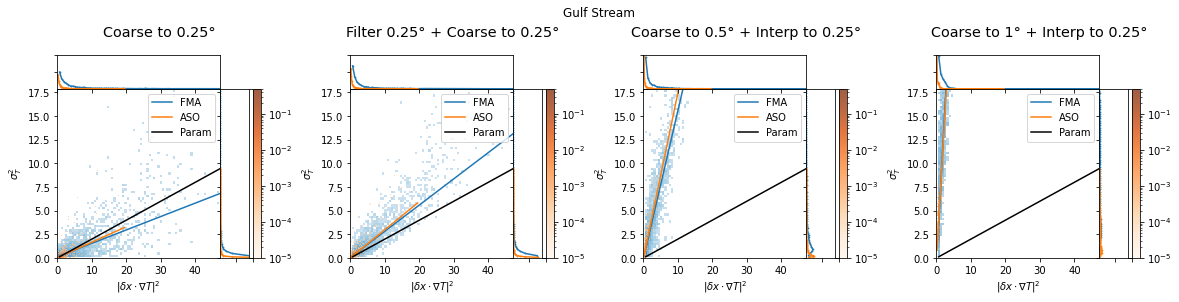

In [86]:
fig, axs = plt.subplots(1, 4, constrained_layout=True, figsize=(16, 4))
fig.suptitle('Gulf Stream')
name_hist = 'hist_var_T'
x = 'diff_T_sqr'
y = 'var_T'
region=0
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = fig.subfigures(1, 4, wspace=0.07)
for a in axs:
    for spine in ['top', 'right', 'bottom', 'left'] :
        a.spines[spine].set_visible(False)
    a.get_xaxis().set_ticks([]); a.get_yaxis().set_ticks([])    
gs = GridSpec(2, 3, width_ratios=[10, 2.0, 1], height_ratios=[2.0, 10], wspace=0, hspace=0)
for i in range(len(filters)) :
    subfigs[i].suptitle(filters[i]['label'], fontsize='x-large')
    big_ax = subfigs[i].add_subplot(gs[1,0]) # bottom left
    top_ax = subfigs[i].add_subplot(gs[0,0], sharex=big_ax) # top left
    right_ax = subfigs[i].add_subplot(gs[1,1], sharey=big_ax) # bottom center
    cbar_ax = subfigs[i].add_subplot(gs[1,2]) # bottom right
    cbar_ax.set(xticks=[], yticks=[])
    hist_joint = margin_hist(hists[region]['HR_Filtered'][i][name_hist], 0, x+'_bin', y+'_bin', top_ax, right_ax, big_ax)
    hist_joint = margin_hist(hists[region+1]['HR_Filtered'][i][name_hist], 1, x+'_bin', y+'_bin', top_ax, right_ax, big_ax)
    x_points = hists[region]['HR_Filtered'][ifilter][name_hist][x+'_bin']
    big_ax.plot(x_points, 0.2*x_points, 'k', label='Param')
    big_ax.set(xlabel=r'$|\delta x \cdot \nabla T|^2$', ylabel=r'$\sigma_T^2$', xscale='linear', yscale='linear')
    big_ax.legend(handles=big_ax.lines, labels=['FMA', 'ASO', 'Param'], loc='upper right')
    big_ax.set(xlim=[0,0.5*hists[region]['HR_Filtered'][i][name_hist][x+'_bin'].max()],\
              ylim=[0,0.5*hists[region]['HR_Filtered'][i][name_hist][y+'_bin'].max()])
    subfigs[i].colorbar(hist_joint, ax=cbar_ax, anchor=(0.0, 0.0),pad=0.25,fraction=1.)
plt.show()

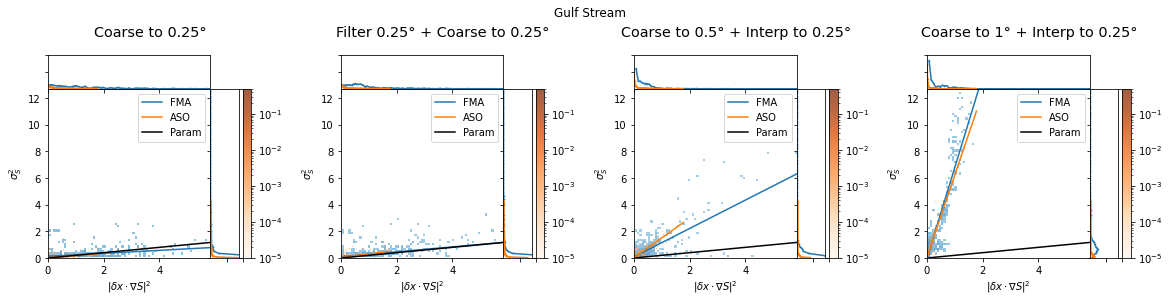

In [163]:
fig, axs = plt.subplots(1, 4, constrained_layout=True, figsize=(16, 4))
fig.suptitle('Gulf Stream')
name_hist = 'hist_var_S'
x = 'diff_S_sqr'
y = 'var_S'
region=0
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = fig.subfigures(1, 4, wspace=0.07)
for a in axs:
    for spine in ['top', 'right', 'bottom', 'left'] :
        a.spines[spine].set_visible(False)
    a.get_xaxis().set_ticks([]); a.get_yaxis().set_ticks([])    
gs = GridSpec(2, 3, width_ratios=[10, 2.0, 1], height_ratios=[2.0, 10], wspace=0, hspace=0)
for i in range(len(filters)) :
    subfigs[i].suptitle(filters[i]['label'], fontsize='x-large')
    big_ax = subfigs[i].add_subplot(gs[1,0]) # bottom left
    top_ax = subfigs[i].add_subplot(gs[0,0], sharex=big_ax) # top left
    right_ax = subfigs[i].add_subplot(gs[1,1], sharey=big_ax) # bottom center
    cbar_ax = subfigs[i].add_subplot(gs[1,2]) # bottom right
    cbar_ax.set(xticks=[], yticks=[])
    hist_joint = margin_hist(hists[region]['HR_Filtered'][i][name_hist], 0, x+'_bin', y+'_bin', top_ax, right_ax, big_ax)
    hist_joint = margin_hist(hists[region+1]['HR_Filtered'][i][name_hist], 1, x+'_bin', y+'_bin', top_ax, right_ax, big_ax)
    x_points = hists[region]['HR_Filtered'][ifilter][name_hist][x+'_bin']
    big_ax.plot(x_points, 0.2*x_points, 'k', label='Param')
    big_ax.set(xlabel=r'$|\delta x \cdot \nabla S|^2$', ylabel=r'$\sigma_S^2$', xscale='linear', yscale='linear')
    big_ax.legend(handles=big_ax.lines, labels=['FMA', 'ASO', 'Param'], loc='upper right')
    big_ax.set(xlim=[0,0.5*hists[region]['HR_Filtered'][i][name_hist][x+'_bin'].max()],\
              ylim=[0,0.5*hists[region]['HR_Filtered'][i][name_hist][y+'_bin'].max()])
    subfigs[i].colorbar(hist_joint, ax=cbar_ax, anchor=(0.0, 0.0),pad=0.25,fraction=1.)
plt.show()

Observations:
- Clearly, filtering/coarsening scheme change a lot the histograms of 2D distributions of the subgrid variance vs. its parametrization.
- When coarsening onto lower resolution grids, we smooth more the fields and therefore suppress the strong gradients, so the points of histograms are all concentrated at relatively low gradients. At the same time, the subgrid variance increases in general, since there is more and more statistical variance that is cut by the filter and goes to the subgrid side. It can be clearly see from the last plot with the most coarened data: the gradients are small, but the subgrid variance is present for a significant number of points, which makes the histogram look almost vertical. If we coarse on a lower resolution grid, it will become even more vertical.
- Coefficient $c$ is proportional to the filtering parameter (relation between the grid sizes)


## Linear fit of histograms (estimation of the coefficient c in the parametrization) 

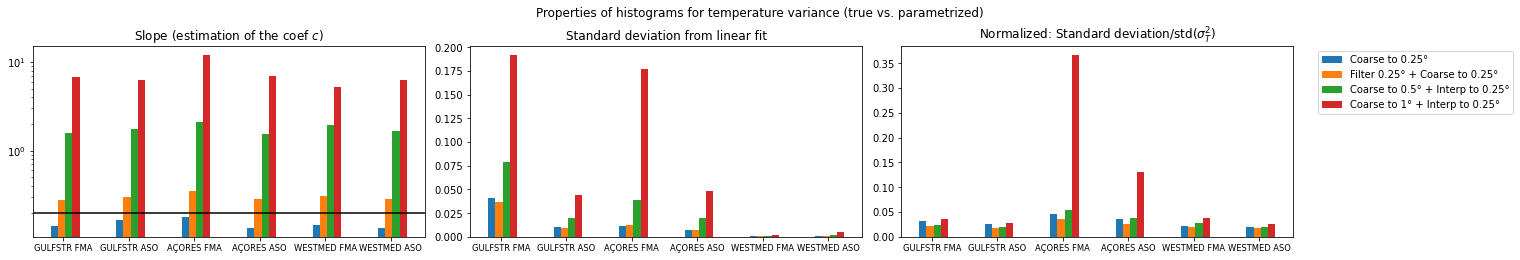

In [87]:
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(21, 3.5))
fig.suptitle('Properties of histograms for temperature variance (true vs. parametrized)')
name_hist = 'hist_var_T'
x = np.arange(6)
bar_width = 0.11
for ifilter in range(len(filters)) :
    ax[0].bar(x+ifilter*bar_width, [hists[region]['HR_Filtered'][ifilter][name_hist].attrs['slope'] for region in range(len(data))], width=bar_width)
    ax[1].bar(x+ifilter*bar_width, [np.sqrt(hists[region]['HR_Filtered'][ifilter][name_hist].attrs['residuals']) \
                                    for region in range(len(data))], width=bar_width, label=filters[ifilter]['label'])
    ax[2].bar(x+ifilter*bar_width, [np.sqrt(hists[region]['HR_Filtered'][ifilter][name_hist].attrs['residuals'])/data[region]['HR_Filtered'][ifilter]['var_T'][bord_cut].std() \
                                    for region in range(len(data))], width=bar_width, label=filters[ifilter]['label'])
for axis in ax :
    axis.set_xticks(x + 1.25*bar_width)
    axis.set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=10)
    axis.xaxis.set_tick_params(labelsize='small')
    
ax[0].axhline(y=0.2, color='k')
ax[0].set(title=r'Slope (estimation of the coef $c$)')
ax[0].set(yscale='log')
    
ax[1].set(title=r'Standard deviation from linear fit')
ax[1].set(yscale='linear')

ax[2].set(title=r'Normalized: Standard deviation/std($\sigma_T^2$)')
ax[2].set(yscale='linear')

ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

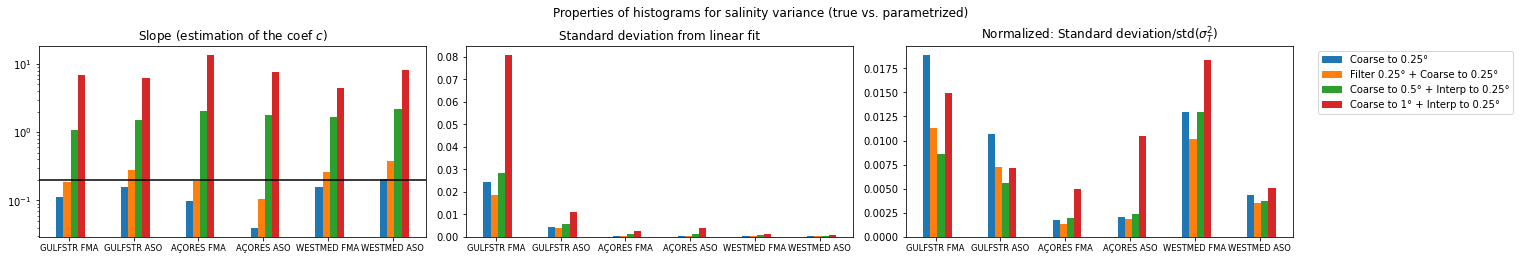

In [164]:
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(21, 3.5))
fig.suptitle('Properties of histograms for salinity variance (true vs. parametrized)')
name_hist = 'hist_var_S'
x = np.arange(6)
bar_width = 0.11
for ifilter in range(len(filters)) :
    ax[0].bar(x+ifilter*bar_width, [hists[region]['HR_Filtered'][ifilter][name_hist].attrs['slope'] for region in range(len(data))], width=bar_width)
    ax[1].bar(x+ifilter*bar_width, [np.sqrt(hists[region]['HR_Filtered'][ifilter][name_hist].attrs['residuals']) \
                                    for region in range(len(data))], width=bar_width, label=filters[ifilter]['label'])
    ax[2].bar(x+ifilter*bar_width, [np.sqrt(hists[region]['HR_Filtered'][ifilter][name_hist].attrs['residuals'])/data[region]['HR_Filtered'][ifilter]['var_T'][bord_cut].std() \
                                    for region in range(len(data))], width=bar_width, label=filters[ifilter]['label'])
for axis in ax :
    axis.set_xticks(x + 1.25*bar_width)
    axis.set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=10)
    axis.xaxis.set_tick_params(labelsize='small')
    
ax[0].axhline(y=0.2, color='k')
ax[0].set(title=r'Slope (estimation of the coef $c$)')
ax[0].set(yscale='log')
    
ax[1].set(title=r'Standard deviation from linear fit')
ax[1].set(yscale='linear')

ax[2].set(title=r'Normalized: Standard deviation/std($\sigma_T^2$)')
ax[2].set(yscale='linear')

ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [166]:
for ifilter in range(len(filters)) :
    filters[ifilter]['coef_T'] = np.mean([hists[i]['HR_Filtered'][ifilter]['hist_var_T'].attrs['slope'] for i in range(len(data))])
    filters[ifilter]['coef_S'] = np.mean([hists[i]['HR_Filtered'][ifilter]['hist_var_S'].attrs['slope'] for i in range(len(data))])

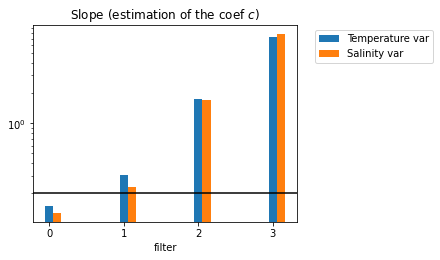

In [180]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(6, 3.5))
x = np.arange(len(filters))
bar_width = 0.11
ax.bar(x, [filters[ifilter]['coef_T'] for ifilter in range(len(filters))], width=bar_width, label='Temperature var')
ax.bar(x+bar_width, [filters[ifilter]['coef_S'] for ifilter in range(len(filters))], width=bar_width, label='Salinity var')
ax.set_xticks(x)
#ax.set_xticklabels([filters[ifilter]['label'] for ifilter in range(len(filters))],fontsize=6)
ax.axhline(y=0.2, color='k')
ax.set(xlabel='filter', title=r'Slope (estimation of the coef $c$)')
ax.set(yscale='log')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Observations:
- The choice of the adjustable parameter $c$ in the deterministic parametrization for the temperature subgrid variance depends strongly on the chosen averaging procedure.
- The value of $c=0.2$ proposed in the paper lies somewhere in between slopes obtained coarsed only and filtered+coarsed data sets.
- Evaluation of STD of the histograms 

# Predictors for density correction

Summing up two assumptions discussed above, here we will focus on the predictors for the the density error, which are:

$$ P_T \equiv \frac{1}{2} \frac{\partial^2 \rho (\bar{T}, \bar{S})}{\partial \bar{T}^2} |\delta \textbf{x} \cdot \nabla \overline{T}|^2 $$
$$ P_S \equiv \frac{1}{2} \frac{\partial^2 \rho (\bar{T}, \bar{S})}{\partial \bar{S}^2} |\delta \textbf{x} \cdot \nabla \overline{S}|^2 $$
$$ P_{TS} \equiv \frac{\partial^2 \rho (\bar{T}, \bar{S})}{\partial \bar{T} \partial \bar{S}} |\delta \textbf{x} \cdot \nabla \overline{S}| |\delta \textbf{x} \cdot \nabla \overline{T}| $$
And their sum:
$$ P_{total} \equiv P_T + P_{TS} + P_S $$
Then, the density error according to the proposed parametrization is:
$$ \rho_c \approx c P_T \quad \text{or} \quad \rho_c \approx c P_{total} $$ 
where the constant $c$ comes from the parametrization of the subgrid variances. </br>
Note that these quantities are evaluated with the use of the filtered fields only (there is no information needed about the subgrid quantities), so they can be also evaluated for eORCA025 data (see next section).

Compute the predictors:

In [89]:
%%time
for i in range(len(data)) :
    for ds in [data[i]['HR']] + [data[i]['HR_Filtered'][ifilter] for ifilter in range(len(filters))] + [data[i]['LR']] :
        ds["predictor_T"] = 0.5*ds['rho_ct_ct']*ds["diff_T_sqr"]
        ds["predictor_S"] = 0.5*ds['rho_sa_sa']*ds["diff_S_sqr"]
        ds["predictor_TS"] = ds['rho_sa_ct']*np.sqrt(ds["diff_T_sqr"])*np.sqrt(ds["diff_S_sqr"])
        ds["predictor_total"] = ds["predictor_T"] + ds["predictor_TS"] + ds["predictor_S"]

CPU times: user 2.24 s, sys: 0 ns, total: 2.24 s
Wall time: 2.23 s


Compute some stats:

In [123]:
%%time
for i in range(len(data)) :
    for ds in [data[i]['HR_Filtered'][ifilter] for ifilter in range(len(filters))] + [data[i]['LR']] :
        for quantity in ["predictor_T", "predictor_S", "predictor_TS", "predictor_total"] :
            ds.attrs['mean_' + quantity] = ds[quantity].mean().compute()
            ds.attrs['std_' + quantity] = ds[quantity].std().compute()
            ds['normalized_'+quantity] = ((ds[quantity]-ds.attrs['mean_' + quantity])/ds.attrs['std_' + quantity]).compute()

CPU times: user 26.2 s, sys: 542 ms, total: 26.8 s
Wall time: 1min 7s


In [124]:
%%time
for i in range(len(data)) :
    for ds in [data[i]['HR_Filtered'][ifilter] for ifilter in range(len(filters))]:
        for quantity in ["sigma0_delta"] :
            ds.attrs['mean_' + quantity] = ds[quantity].mean().compute()
            ds.attrs['std_' + quantity] = ds[quantity].std().compute()
            ds['normalized_'+quantity] = ((ds[quantity]-ds.attrs['mean_' + quantity])/ds.attrs['std_' + quantity]).compute()

CPU times: user 1.05 s, sys: 61.7 ms, total: 1.11 s
Wall time: 4.4 s


## Contribution of each term

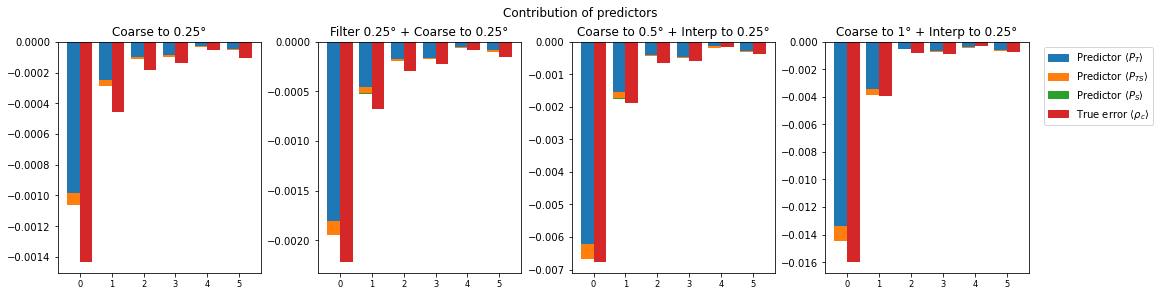

In [182]:
fig, ax = plt.subplots(1, 4, constrained_layout=True, figsize=(16, 4), sharey=False)
fig.suptitle(r'Contribution of predictors')
x = np.arange(6)
bar_width = 0.4
for ifilter in range(len(filters)) :
    coef = filters[ifilter]['coef_T']
    for i in range(len(data)) :
        ds = data[i]['HR_Filtered'][ifilter]
        ax[ifilter].bar(x[i], coef*ds.attrs['mean_predictor_T'], width=bar_width, color=line_colors[0])
        ax[ifilter].bar(x[i], coef*ds.attrs['mean_predictor_TS'], bottom=coef*ds.attrs['mean_predictor_T'], width=bar_width, color=line_colors[1])
        ax[ifilter].bar(x[i], coef*ds.attrs['mean_predictor_S'], bottom=coef*(ds.attrs['mean_predictor_T']+ds.attrs['mean_predictor_TS']), width=bar_width, color=line_colors[2])
        ax[ifilter].bar(x[i]+bar_width, ds.attrs['mean_sigma0_delta'], width=bar_width, color=line_colors[3])
    ax[ifilter].set(title=filters[ifilter]['label'])
patches = [None]*4
patches[0] = mpatches.Patch(color=line_colors[0], label=r'Predictor $\langle P_T \rangle$')
patches[1] = mpatches.Patch(color=line_colors[1], label=r'Predictor $\langle P_{TS} \rangle$')
patches[2] = mpatches.Patch(color=line_colors[2], label=r'Predictor $\langle  P_S \rangle$')
patches[3] = mpatches.Patch(color=line_colors[3], label=r'True error $\langle \rho_c \rangle$')
ax[-1].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
for axis in ax :
    axis.set_xticks(x + 0.5*bar_width)
    #axis.axhline(y=1., color='k')
    #axis.set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=10)
    axis.set_xticklabels([region for region in range(len(data))],fontsize=10)
    axis.xaxis.set_tick_params(labelsize='small')
    axis.set(yscale='linear')
plt.show()

## Histograms

In [183]:
%%time
normalized = False
for quantity in ["predictor_T", "predictor_S", "predictor_TS", "predictor_total"] :
    if normalized :
        variable = 'normalized_'+quantity
    else :
        variable = quantity
    for i in range(len(data)) :
        # reference histogram (to make same bins for all histograms - better for comparison)
        ref_histo = compute_1D_histogram(data[i]['HR_Filtered'][3][bord_cut], variable, nb_of_bins, bins=None).compute()
        ref_bins = ref_histo[variable+'_bin'].values

        hists[i]['LR'][variable] = compute_1D_histogram(data[i]['LR'][bord_cut], variable, nb_of_bins, bins=ref_bins).compute()
        for ifilter in range(len(filters)) :
            hists[i]['HR_Filtered'][ifilter][variable] = compute_1D_histogram(data[i]['HR_Filtered'][ifilter][bord_cut], variable, nb_of_bins, bins=ref_bins)

CPU times: user 13.4 s, sys: 229 ms, total: 13.6 s
Wall time: 31.9 s


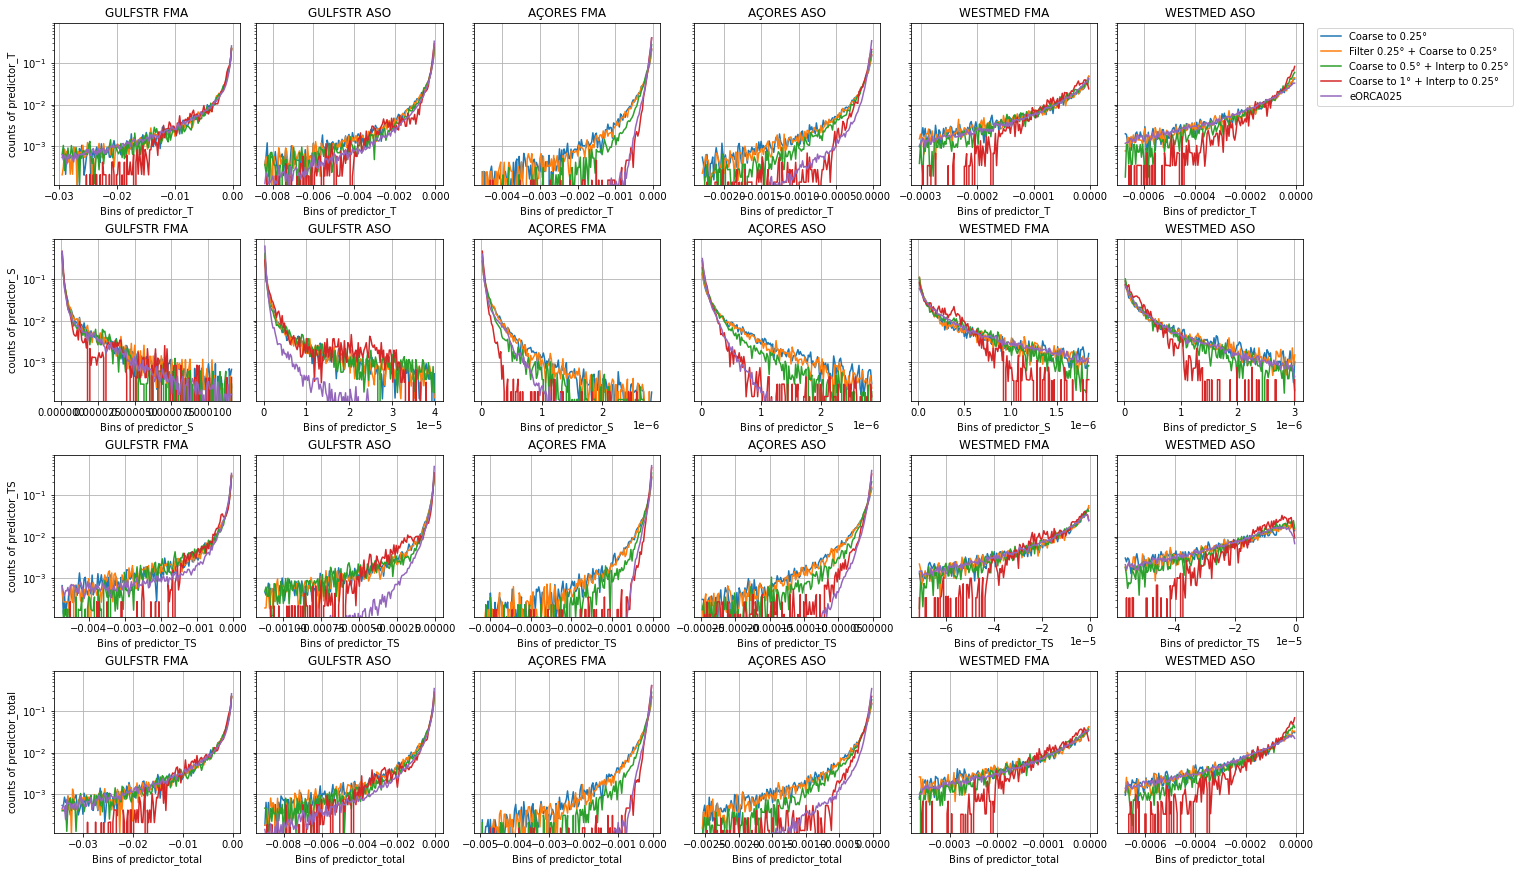

In [114]:
fig, ax = plt.subplots(nrows=4, ncols=len(data), constrained_layout=True, figsize=(3.5*len(data), 3*4), sharey=True)
for row, quantity in enumerate(["predictor_T", "predictor_S", "predictor_TS", "predictor_total"]) :
    for i in range(len(data)) :
        for ifilter in range(len(filters)) :
            ds = hists[i]['HR_Filtered'][ifilter]
            ds[quantity].plot(ax=ax[row,i], label=ds['label'], color=line_colors[ifilter])
        hists[i]['LR'][quantity].plot(ax=ax[row,i], label=hists[i]['LR']['label'], color=line_colors[len(filters)])
        ax[row,i].set(title=data[i]['label'], yscale='log', ylabel='', xlabel=r'Bins of '+quantity); ax[row,i].grid(True)
    ax[row,0].set(ylabel='counts of '+quantity)
ax[0,-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [94]:
# %%time
# fig, ax = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(15, 7))
# fig.suptitle(r'Mean and starndard deviation')
# x = np.arange(len(data))
# bar_width = 0.11

# for col, quantity in enumerate(['diff_T_sqr_dens_deriv', 'diff_S_sqr_dens_deriv']) :
#     for row, stat_mom in enumerate(['mean', 'std']) :
#         for ifilter in range(len(filters)) :
#             ax[row,col].bar(x+(ifilter)*bar_width, [data[region]['HR_Filtered'][ifilter].attrs[stat_mom+'_'+quantity] for region in range(len(data))], width=bar_width, \
#                       label=filters[ifilter]['label'])
#         ax[row,col].bar(x+4*bar_width, [data[region]['LR'].attrs[stat_mom+'_'+quantity] for region in range(len(data))], width=bar_width, label='eORCA025')
#         ax[row,col].set_xticks(x + 1.25*bar_width)
#         ax[row,col].set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=10)
#         ax[row,col].xaxis.set_tick_params(labelsize='small')
#         ax[row,col].set(yscale='linear')
#         ax[row,col].set(title=stat_mom+'_'+quantity)
# ax[0,0].set(title=r'Mean $P_T$')
# ax[1,0].set(title=r'STD $P_T$')
# ax[0,1].set(title=r'Mean $P_S$')
# ax[1,1].set(title=r'STD $P_S$')
# ax[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()

# Results of density parametrization vs its "true" error

From (Stanley et al 2021), the density correction is determined mainly by the temperature subgrid variance $\sigma^2_T$ and the local second derivative of the density with the respect to temperature (known from the EOS) evaluated on the basis of filtered fields.
It is proposed to estimate the temperature subgrid variance with local gradient (computed numerically through finite differences):
$$ \rho_c = \frac{1}{2} \frac{\partial^2 \rho (\bar{T}, \bar{S})}{\partial \bar{T}^2} \sigma_T^2 $$
$$ \sigma_T^2 \approx \mathscr{s}_T^2 \equiv c |\delta \textbf{x} \cdot \nabla \bar{T}|^2 $$ 
where the coefficient $c$ can depend on the resolution. The theoretcal estimate is $c=1/12$. The values found from fitting of the data is $c=0.2$.

In [60]:
c=0.2

In [61]:
%%time
for i in range(len(data)) :
    for ds in [data[i]['HR_Filtered'][ifilter] for ifilter in range(len(filters))] + [data[i]['LR']] :
        ds['param_sigma0_delta'] = c*ds["diff_T_sqr_dens_deriv"]

CPU times: user 216 ms, sys: 39.8 ms, total: 256 ms
Wall time: 201 ms


## Plot snapshots

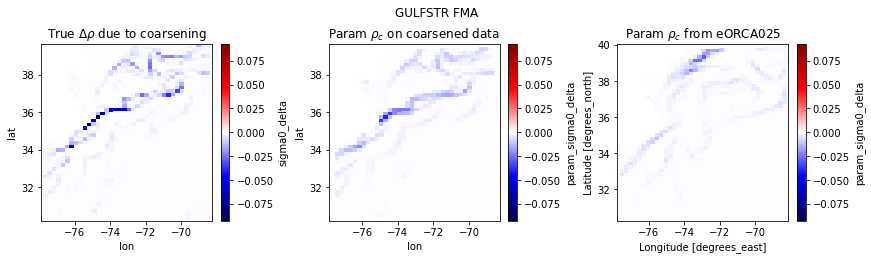

In [62]:
fig, ax = plt.subplots(1, 3, constrained_layout=True, figsize=(12, 3.5))
region = 0
ifilter = 0
fig.suptitle(data[region]['label'])
cmap = 'seismic'

plot0 = data[region]['HR_Filtered'][ifilter].isel(time_counter=-1)['sigma0_delta'][bord_cut].plot(x='lon', y='lat', ax=ax[0], cmap=cmap)
ax[0].set(title=r'True $\Delta \rho$ due to coarsening')

plot1 = data[region]['HR_Filtered'][ifilter].isel(time_counter=-1)['param_sigma0_delta'][bord_cut].plot(x='lon', y='lat', ax=ax[1], \
                                                                                                        cmap=cmap, vmin=plot0.colorbar.vmin, vmax=plot0.colorbar.vmax)
ax[1].set(title=r'Param $\rho_c$ on coarsened data')
plot1.colorbar = plot0.colorbar

data[region]['LR'].isel(time_counter=-1)['param_sigma0_delta'][bord_cut].plot(x='lon', y='lat', ax=ax[2], cmap=cmap, vmin=plot0.colorbar.vmin, vmax=plot0.colorbar.vmax)
ax[2].set(title=r'Param $\rho_c$ from eORCA025')
plt.show()

## 2D histograms (to estimate coefficient c)

In [63]:
%%time
name_hist = 'hist_delta_sigma'
x = 'param_sigma0_delta_without_c'
y = 'sigma0_delta'
for i in range(len(data)) :
    # reference histogram
    ref_case = 3
    hists[i]['HR_Filtered'][ref_case][name_hist] = compute_2D_histogram(data[i]['HR_Filtered'][ref_case][bord_cut], x, y, nb_of_bins).compute()
    ref_hist = hists[i]['HR_Filtered'][ref_case][name_hist]
    bins = [ref_hist[x+'_bin'].values, ref_hist[y+'_bin'].values]
    for ifilter in range(len(filters)) :
        hists[i]['HR_Filtered'][ifilter][name_hist] = compute_2D_histogram(data[i]['HR_Filtered'][ifilter][bord_cut], x, y, nb_of_bins, bins=bins).compute()
        [hists[i]['HR_Filtered'][ifilter][name_hist].attrs['slope'], hists[i]['HR_Filtered'][ifilter][name_hist].attrs['increment'], \
         hists[i]['HR_Filtered'][ifilter][name_hist].attrs['residuals'], hists[i]['HR_Filtered'][ifilter][name_hist].attrs['mean_x'], hists[i]['HR_Filtered'][ifilter][name_hist].attrs['mean_y']] = \
        fit_2D_histogram(hists[i]['HR_Filtered'][ifilter][name_hist])

CPU times: user 3.55 s, sys: 93.2 ms, total: 3.64 s
Wall time: 8.25 s


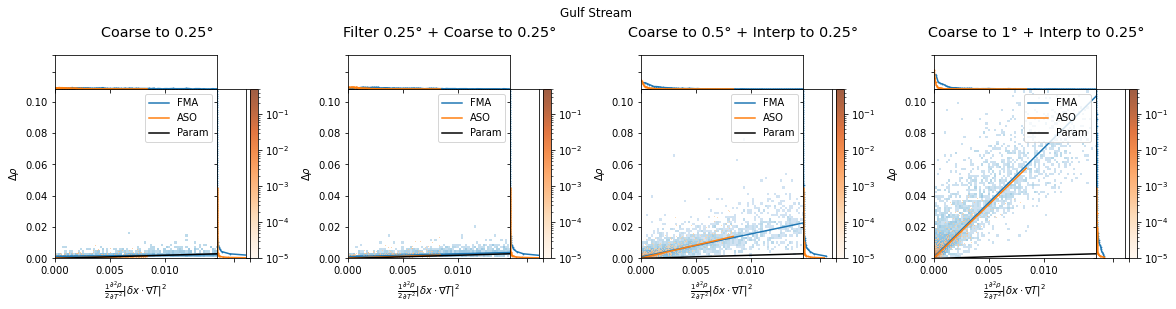

In [64]:
fig, axs = plt.subplots(1, 4, constrained_layout=True, figsize=(16, 4))
fig.suptitle('Gulf Stream')
name_hist = 'hist_delta_sigma'
x = 'param_sigma0_delta_without_c'
y = 'sigma0_delta'
region=0
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = fig.subfigures(1, 4, wspace=0.07)
for a in axs:
    for spine in ['top', 'right', 'bottom', 'left'] :
        a.spines[spine].set_visible(False)
    a.get_xaxis().set_ticks([]); a.get_yaxis().set_ticks([])    
gs = GridSpec(2, 3, width_ratios=[10, 2.0, 1], height_ratios=[2.0, 10], wspace=0, hspace=0)
for i in range(len(filters)) :
    subfigs[i].suptitle(filters[i]['label'], fontsize='x-large')
    big_ax = subfigs[i].add_subplot(gs[1,0]) # bottom left
    top_ax = subfigs[i].add_subplot(gs[0,0], sharex=big_ax) # top left
    right_ax = subfigs[i].add_subplot(gs[1,1], sharey=big_ax) # bottom center
    cbar_ax = subfigs[i].add_subplot(gs[1,2]) # bottom right
    cbar_ax.set(xticks=[], yticks=[])
    hist_joint = margin_hist(hists[region]['HR_Filtered'][i][name_hist], 0, x+'_bin', y+'_bin', top_ax, right_ax, big_ax)
    hist_joint = margin_hist(hists[region+1]['HR_Filtered'][i][name_hist], 1, x+'_bin', y+'_bin', top_ax, right_ax, big_ax)
    x_points = hists[region]['HR_Filtered'][ifilter][name_hist][x+'_bin']
    big_ax.plot(x_points, 0.2*x_points, 'k', label='Param')
    big_ax.set(xlabel=r'$\frac{1}{2} \frac{\partial^2 \rho}{\partial T^2}|\delta x \cdot \nabla T|^2$', ylabel=r'$\Delta \rho$', xscale='linear', yscale='linear')
    big_ax.legend(handles=big_ax.lines, labels=['FMA', 'ASO', 'Param'], loc='upper right')
    big_ax.set(xlim=[0,0.5*hists[region]['HR_Filtered'][i][name_hist][x+'_bin'].max()],\
              ylim=[0,0.5*hists[region]['HR_Filtered'][i][name_hist][y+'_bin'].max()])
    subfigs[i].colorbar(hist_joint, ax=cbar_ax, anchor=(0.0, 0.0),pad=0.25,fraction=1.)
plt.show()

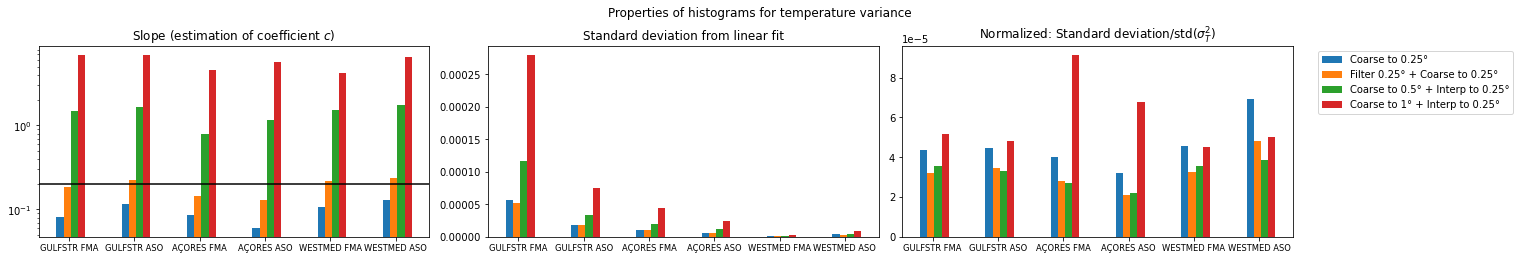

In [65]:
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(21, 3.5))
fig.suptitle('Properties of histograms for temperature variance')
name_hist = 'hist_delta_sigma'
x = np.arange(6)
bar_width = 0.11
for ifilter in range(len(filters)) :
    ax[0].bar(x+ifilter*bar_width, [hists[region]['HR_Filtered'][ifilter][name_hist].attrs['slope'] for region in range(len(data))], width=bar_width)
    ax[1].bar(x+ifilter*bar_width, [np.sqrt(hists[region]['HR_Filtered'][ifilter][name_hist].attrs['residuals']) \
                                    for region in range(len(data))], width=bar_width, label=filters[ifilter]['label'])
    ax[2].bar(x+ifilter*bar_width, [np.sqrt(hists[region]['HR_Filtered'][ifilter][name_hist].attrs['residuals'])/data[region]['HR_Filtered'][ifilter]['var_T'][bord_cut].std() \
                                    for region in range(len(data))], width=bar_width, label=filters[ifilter]['label'])
for axis in ax :
    axis.set_xticks(x + 1.25*bar_width)
    axis.set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=10)
    axis.xaxis.set_tick_params(labelsize='small')
    
ax[0].axhline(y=0.2, color='k')
ax[0].set(title=r'Slope (estimation of coefficient $c$)')
ax[0].set(yscale='log')
    
ax[1].set(title=r'Standard deviation from linear fit')
ax[1].set(yscale='linear')

ax[2].set(title=r'Normalized: Standard deviation/std($\sigma_T^2$)')
ax[2].set(yscale='linear')

ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Spatial covariance vs time

In [66]:
%%time
for i in range(len(data)) :
    for ifilter in range(len(filters)):
        hists[i]['HR_Filtered'][ifilter]['corr_param_sigma0_delta_vs_true_delta'] = xr.corr(data[i]['HR_Filtered'][ifilter]['param_sigma0_delta'], data[i]['HR_Filtered'][ifilter]['sigma0_delta'], \
                                                                          dim=['x', 'y']).compute()

CPU times: user 3.34 s, sys: 105 ms, total: 3.44 s
Wall time: 7.22 s


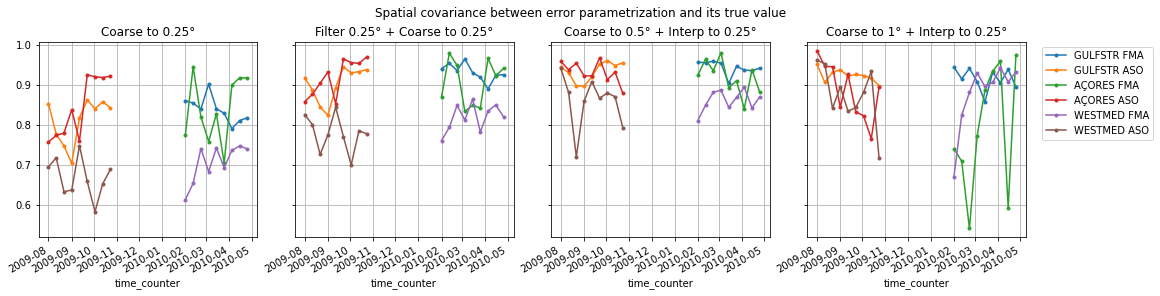

In [67]:
fig, ax = plt.subplots(1, 4, constrained_layout=True, figsize=(16, 4), sharey=True) 
fig.suptitle('Spatial covariance between error parametrization and its true value')
for ifilter in range(len(filters)):
    for i in range(len(data)) :
        hists[i]['HR_Filtered'][ifilter]['corr_param_sigma0_delta_vs_true_delta'].plot(ax=ax[ifilter], ls='-', marker='.', label=data[i]['label'])
    ax[ifilter].set(title=filters[ifilter]['label']); ax[ifilter].grid(True)    
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

1D histogram of parametrized density error (for filtered fields and for eORCA025) :

In [68]:
%%time
for i in range(len(data)) :
    # reference histogram
    ref_histo = compute_1D_histogram(data[i]['HR_Filtered'][3][bord_cut], 'param_sigma0_delta_without_c', nb_of_bins, bins=None).compute()
    ref_bins = ref_histo['param_sigma0_delta_without_c_bin'].values
    
    hists[i]['LR']['param_sigma0_delta'] = compute_1D_histogram(data[i]['LR'][bord_cut], 'param_sigma0_delta_without_c', nb_of_bins, bins=ref_bins).compute()
    for ifilter in range(len(filters)) :
        hists[i]['HR_Filtered'][ifilter]['param_sigma0_delta_without_c'] = compute_1D_histogram(data[i]['HR_Filtered'][ifilter][bord_cut], 'param_sigma0_delta_without_c', nb_of_bins, bins=ref_bins)

CPU times: user 2.54 s, sys: 49.4 ms, total: 2.59 s
Wall time: 5.74 s


In [69]:
%%time
for i in range(len(data)) :
    # reference histogram
    ref_histo = compute_1D_histogram(data[i]['HR_Filtered'][3][bord_cut], 'param_sigma0_delta', nb_of_bins, bins=None).compute()
    ref_bins = ref_histo['param_sigma0_delta_bin'].values
    
    hists[i]['LR']['param_sigma0_delta'] = compute_1D_histogram(data[i]['LR'][bord_cut], 'param_sigma0_delta', nb_of_bins, bins=ref_bins).compute()
    for ifilter in range(len(filters)) :
        hists[i]['HR_Filtered'][ifilter]['param_sigma0_delta'] = compute_1D_histogram(data[i]['HR_Filtered'][ifilter][bord_cut], 'param_sigma0_delta', nb_of_bins, bins=ref_bins)

CPU times: user 2.6 s, sys: 53.4 ms, total: 2.65 s
Wall time: 6.3 s


1D histogram of true density error (for filtered fields only) :

In [70]:
%%time
for i in range(len(data)) :
    # reference histogram
    ref_histo = compute_1D_histogram(data[i]['HR_Filtered'][3][bord_cut], 'sigma0_delta', nb_of_bins, bins=None).compute()
    ref_bins = ref_histo['sigma0_delta_bin'].values
    for ifilter in range(len(filters)) :
        hists[i]['HR_Filtered'][ifilter]['sigma0_delta'] = compute_1D_histogram(data[i]['HR_Filtered'][ifilter][bord_cut], 'sigma0_delta', nb_of_bins, bins=ref_bins)

CPU times: user 1.33 s, sys: 44.6 ms, total: 1.37 s
Wall time: 3.06 s


# Applying density parametrization to eORCA025 and filtered fields

## Histograms

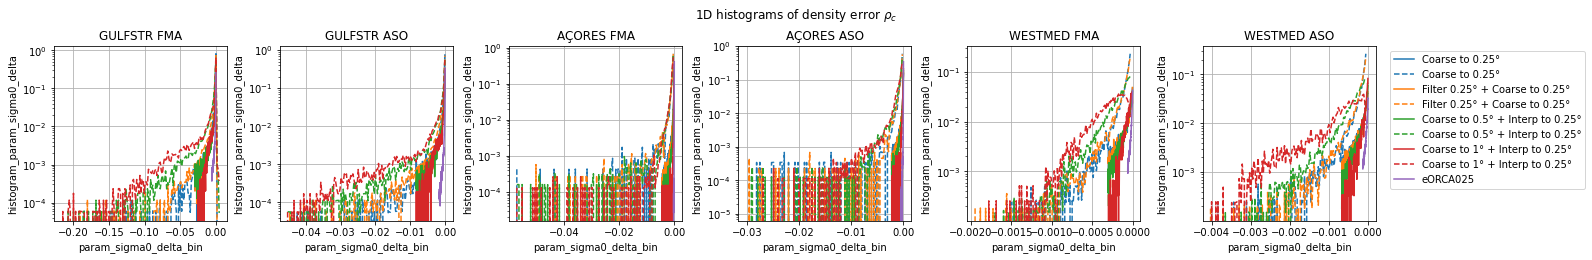

In [71]:
fig, ax = plt.subplots(nrows=1, ncols=6, constrained_layout=True, figsize=(22, 3.5))
fig.suptitle(r'1D histograms of density error $\rho_c$')
for i in range(len(data)) :
    for ifilter in range(len(filters)) :
        ds = hists[i]['HR_Filtered'][ifilter]
        ds['param_sigma0_delta_without_c'].plot(ax=ax[i], label=ds['label'], color=line_colors[ifilter])
        ds['sigma0_delta'].plot(ax=ax[i], label=ds['label'], ls='--')
    hists[i]['LR']['param_sigma0_delta'].plot(ax=ax[i], label=hists[i]['LR']['label'])
    ax[i].set(title=data[i]['label'], yscale='log'); ax[i].grid(True)
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

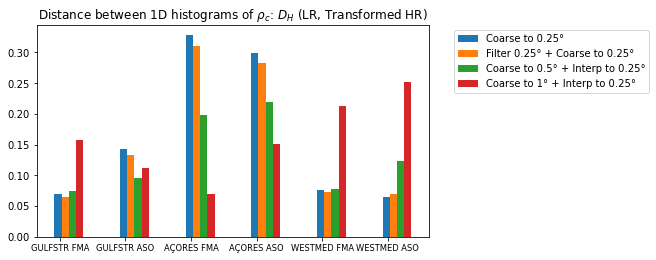

In [72]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(9, 3.5))
name_hist = 'param_sigma0_delta'
ref_dataKey = 'LR'
x = np.arange(len(data))
bar_width = 0.11
for ifilter in range(len(filters)) :
    ax.bar(x+(ifilter+1)*bar_width, [D_H(hists[region]['LR'][name_hist], hists[region]['HR_Filtered'][ifilter][name_hist]) for region in range(len(data))], width=bar_width, \
              label=filters[ifilter]['label'])
ax.set_xticks(x + 1.25*bar_width)
ax.set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=10)
ax.xaxis.set_tick_params(labelsize='small')
ax.set(title=r'Distance between 1D histograms of $\rho_c$: $D_H$ ('+ ref_dataKey +', Transformed HR)')
ax.set(yscale='linear')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Distances between histograms

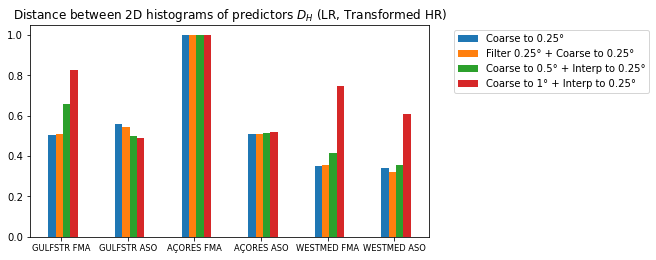

In [73]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(9, 3.5))
name_hist = 'hist_pred'
ref_dataKey = 'LR'
x = np.arange(len(data))
bar_width = 0.11
#ax.bar(x, [D_H(hists[region][ref_dataKey][name_hist], hists[region]['HR'][name_hist]) for region in range(len(data))], width=bar_width, label='eNATL60')
for ifilter in range(len(filters)) :
    ax.bar(x+(ifilter)*bar_width, [D_H(hists[region][ref_dataKey][name_hist], hists[region]['HR_Filtered'][ifilter][name_hist]) for region in range(len(data))], width=bar_width, \
              label=filters[ifilter]['label'])
ax.set_xticks(x + 1.25*bar_width)
ax.set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=10)
ax.xaxis.set_tick_params(labelsize='small')
ax.set(title=r'Distance between 2D histograms of predictors $D_H$ ('+ ref_dataKey +', Transformed HR)')
ax.set(yscale='linear')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

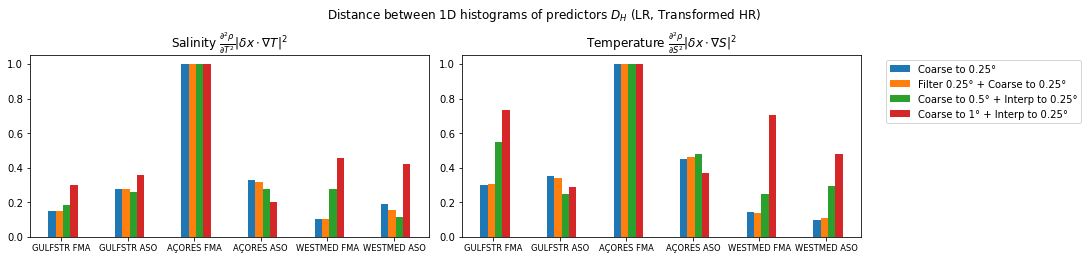

In [74]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15, 3.5))
fig.suptitle(r'Distance between 1D histograms of predictors $D_H$ ('+ ref_dataKey +', Transformed HR)')
name_hist = 'hist_pred'
ref_dataKey = 'LR'
x = np.arange(len(data))
bar_width = 0.11
#ax[0].bar(x, [D_H(hists[region][ref_dataKey][name_hist].sum(dim='diff_T_sqr_dens_deriv_bin'), hists[region]['HR'][name_hist].sum(dim='diff_T_sqr_dens_deriv_bin')) for region in range(len(data))], width=bar_width, label='eNATL60')
#ax[1].bar(x, [D_H(hists[region][ref_dataKey][name_hist].sum(dim='diff_S_sqr_dens_deriv_bin'), hists[region]['HR'][name_hist].sum(dim='diff_S_sqr_dens_deriv_bin')) for region in range(len(data))], width=bar_width, label='eNATL60')
for ifilter in range(len(filters)) :
    ax[0].bar(x+(ifilter)*bar_width, [D_H(hists[region][ref_dataKey][name_hist].sum(dim='diff_T_sqr_dens_deriv_bin'), hists[region]['HR_Filtered'][ifilter][name_hist].sum(dim='diff_T_sqr_dens_deriv_bin')) for region in range(len(data))], width=bar_width, \
              label=filters[ifilter]['label'])
    ax[1].bar(x+(ifilter)*bar_width, [D_H(hists[region][ref_dataKey][name_hist].sum(dim='diff_S_sqr_dens_deriv_bin'), hists[region]['HR_Filtered'][ifilter][name_hist].sum(dim='diff_S_sqr_dens_deriv_bin')) for region in range(len(data))], width=bar_width, \
              label=filters[ifilter]['label'])
for axis in ax:
    axis.set_xticks(x + 1.25*bar_width)
    axis.set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=10)
    axis.xaxis.set_tick_params(labelsize='small')
    axis.set(yscale='linear')
ax[0].set(title=r'Salinity $\frac{\partial^2 \rho}{\partial T^2} |\delta x \cdot \nabla T|^2$')
ax[1].set(title=r'Temperature $\frac{\partial^2 \rho}{\partial S^2} |\delta x \cdot \nabla S|^2$')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()